In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

import sys
src_root = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_root not in sys.path:
    sys.path.append(src_root)

In [2]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

# Create Models

In [3]:
from mda import ModelManager

In [4]:
from itertools import product

manager = ModelManager()

for (scaler, preprocessing, data_type) in product(['standardized', 'normalized'], ['preprocessed', 'non_processed'], ['external', 'augmented']):
    groups = [data_type, scaler]
    name = f"{scaler.capitalize()} {'Preprocessed ' if preprocessing == 'preprocessed' else ''}{data_type.capitalize()}"

    manager.create_model(
        model_name=name,
        model_type=(scaler, 'non_engineered', preprocessing, data_type),
        groups=groups
    )

# Load Data

In [5]:
def to_wide_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms trial-based Tg, Ta, h, Tc data into a wide format with average values.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns including:
                           ['Hc', 'Rc', 'trial', 'Tg', 'Ta', 'Tc']

    Returns:
        pd.DataFrame: Transformed DataFrame in wide format.
    """

    # Group by ID and trial number to generate a unique index per observation
    group_cols = ["Hc", "Rc"]
    df["trial_idx"] = df.groupby(group_cols + ["trial"], sort=False).cumcount()

    # Pivot the DataFrame to wide format
    pivoted = df.pivot(index=group_cols + ["trial_idx"], columns="trial", values=["Tg", "Ta", "Tc"])

    # Flatten MultiIndex columns
    pivoted.columns = [f"{var}_{trial}" for var, trial in pivoted.columns]
    pivoted = pivoted.reset_index()

    # Compute averages
    pivoted["Tg"] = pivoted[[f"Tg_{i}" for i in range(1, 4)]].mean(axis=1).round(2)
    pivoted["Ta"] = pivoted[[f"Ta_{i}" for i in range(1, 4)]].mean(axis=1).round(1)
    pivoted["Tc"] = pivoted[[f"Tc_{i}" for i in range(1, 4)]].mean(axis=1).round(1)

    # Drop trial_idx if not needed
    pivoted = pivoted.rename(columns={"trial_idx": "trial"})

    # Reorder columns nicely
    ordered_cols = (
        group_cols +
        [f"{x}_{i}" for i in range(1, 4) for x in ["Tg", "Ta", "Tc"]] +
        ["Tg", "Ta", "Tc"]
    )
    pivoted = pivoted[ordered_cols]
    
    return pivoted

In [6]:
test_data = load_data(f"../data/processed/test_data.csv", 'test')

test data loaded successfully with 108 rows and 6 columns.


In [7]:
test_data_wide_format = load_data(f"../data/processed/test_data_wide_format.csv", 'test (wide format)')

test (wide format) data loaded successfully with 36 rows and 14 columns.


In [8]:
# Default
dtod = test_data[(test_data['Hc'] == 'dtodactivity') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
dtoc = test_data[(test_data['Hc'] == 'dtodactivity') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])
# Rigorous
rtod = test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
rtoc = test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])
# Cooled
ctod = test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'default')].drop(columns=['Hc', 'Rc'])
ctoc = test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'cooled')].drop(columns=['Hc', 'Rc'])

# Functions

In [9]:
def enhanced_predict(data, manager, mode='orig'):
    df = data.copy()
    
    if mode in ['orig', 'aug']:
        # For original or augmented models only
        group = "original_models" if mode == 'orig' else "augmented_models"
        models = manager.get_models_by_group(group)
        
        # Process each model
        for name, model in models.items():
            prefix = name  # Use model name as prefix
            
            # Make prediction and calculate error
            predictions = model.predict(df[['Tg', 'Ta']])
            df[f'{prefix}Tp'] = np.round(predictions, 1)
            if 'Tc' in df.columns:
                df[f'{prefix}Tp_err'] = df['Tc'] - df[f'{prefix}Tp']
    
    else:  # mode == 'all'
        # Process all models
        for name, model in manager.models.items():
            prefix = name  # Use model name as prefix
            
            # Make prediction and calculate error
            if 'ensemble' not in model.name:
                predictions = model.predict(df[['Tg', 'Ta']])
            else:
                predictions = model.predict(data=df, target_col='Tc')
            df[f'{prefix}Tp'] = np.round(predictions, 1)
            if 'Tc' in df.columns:
                df[f'{prefix}Tp_err'] = df['Tc'] - df[f'{prefix}Tp']
    
    return df

def calculate_and_print_metrics_with_manager(data, y_true_col, manager, mode='all'):
    """
    Calculate and print metrics per trial and for the whole dataset using ModelManager.
    
    Parameters:
        data (pd.DataFrame): The dataset containing true and predicted values.
        y_true_col (str): The column name for true values.
        manager (ModelManager): The model manager instance.
        mode (str): 'orig', 'aug', or 'all' to select which models to use.
    """
    def calculate_metrics(y_true, y_pred):
        metrics = {
            'RMSE': root_mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'R²': r2_score(y_true, y_pred)
        }
        return metrics

    # First get predictions using enhanced_predict
    df = enhanced_predict(data, manager, mode=mode)
    
    # Determine which models were used based on mode
    if mode == 'orig':
        models = manager.get_models_by_group("original_models")
    elif mode == 'aug':
        models = manager.get_models_by_group("augmented_models")
    else:  # mode == 'all'
        models = manager.models
    
    # Create list of prediction column names
    y_pred_cols = [f'{name}Tp' for name in models.keys()]
    
    # Calculate metrics per trial if 'trial' column exists
    if 'trial' in df.columns:
        trials = df['trial'].unique()
        for trial in trials:
            trial_data = df[df['trial'] == trial]
            print(f"\nMetrics for Trial {trial}:")
            for pred_col in y_pred_cols:
                metrics = calculate_metrics(trial_data[y_true_col], trial_data[pred_col])
                print(f"  {pred_col}: {metrics}")
    
    # Calculate metrics for the whole dataset
    print("\nMetrics for the Whole Dataset:")
    for pred_col in y_pred_cols:
        metrics = calculate_metrics(df[y_true_col], df[pred_col])
        print(f"  {pred_col}: {metrics}")
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.scatter(df['Tg'], df[y_true_col], alpha=0.6, label="Actual", color='black')
    for pred_col in y_pred_cols:
        plt.scatter(df['Tg'], df[pred_col], alpha=0.6, label=pred_col)
    
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return df

# Evaluate

## Default

### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.329916 0.273025 0.108844 -0.100673
Standardized Preprocessed Augmented 0.327005 0.237768 0.106932 -0.081340
              Standardized External 0.323648 0.253362 0.104748 -0.059251
             Standardized Augmented 0.375309 0.267242 0.140857 -0.424396
   Normalized Preprocessed External 0.330045 0.249305 0.108929 -0.101533
  Normalized Preprocessed Augmented 0.328200 0.275600 0.107715 -0.089257
                Normalized External 0.324377 0.269193 0.105221 -0.064028
               Normalized Augmented 0.317834 0.259826 0.101018 -0.021534

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.486309 0.409470 0.236496 -0.002812
Standardized Preprocessed Augmented 0.513577 0.384668 0.263762 -0.118424
              Stand

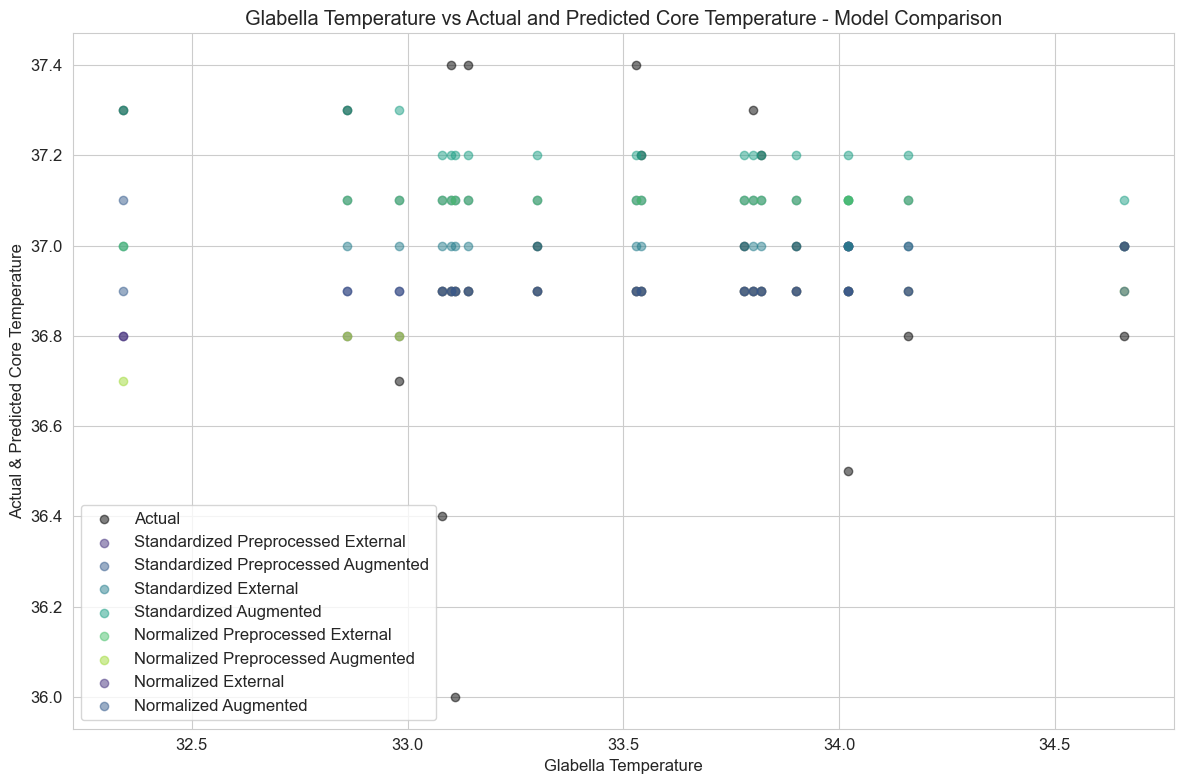

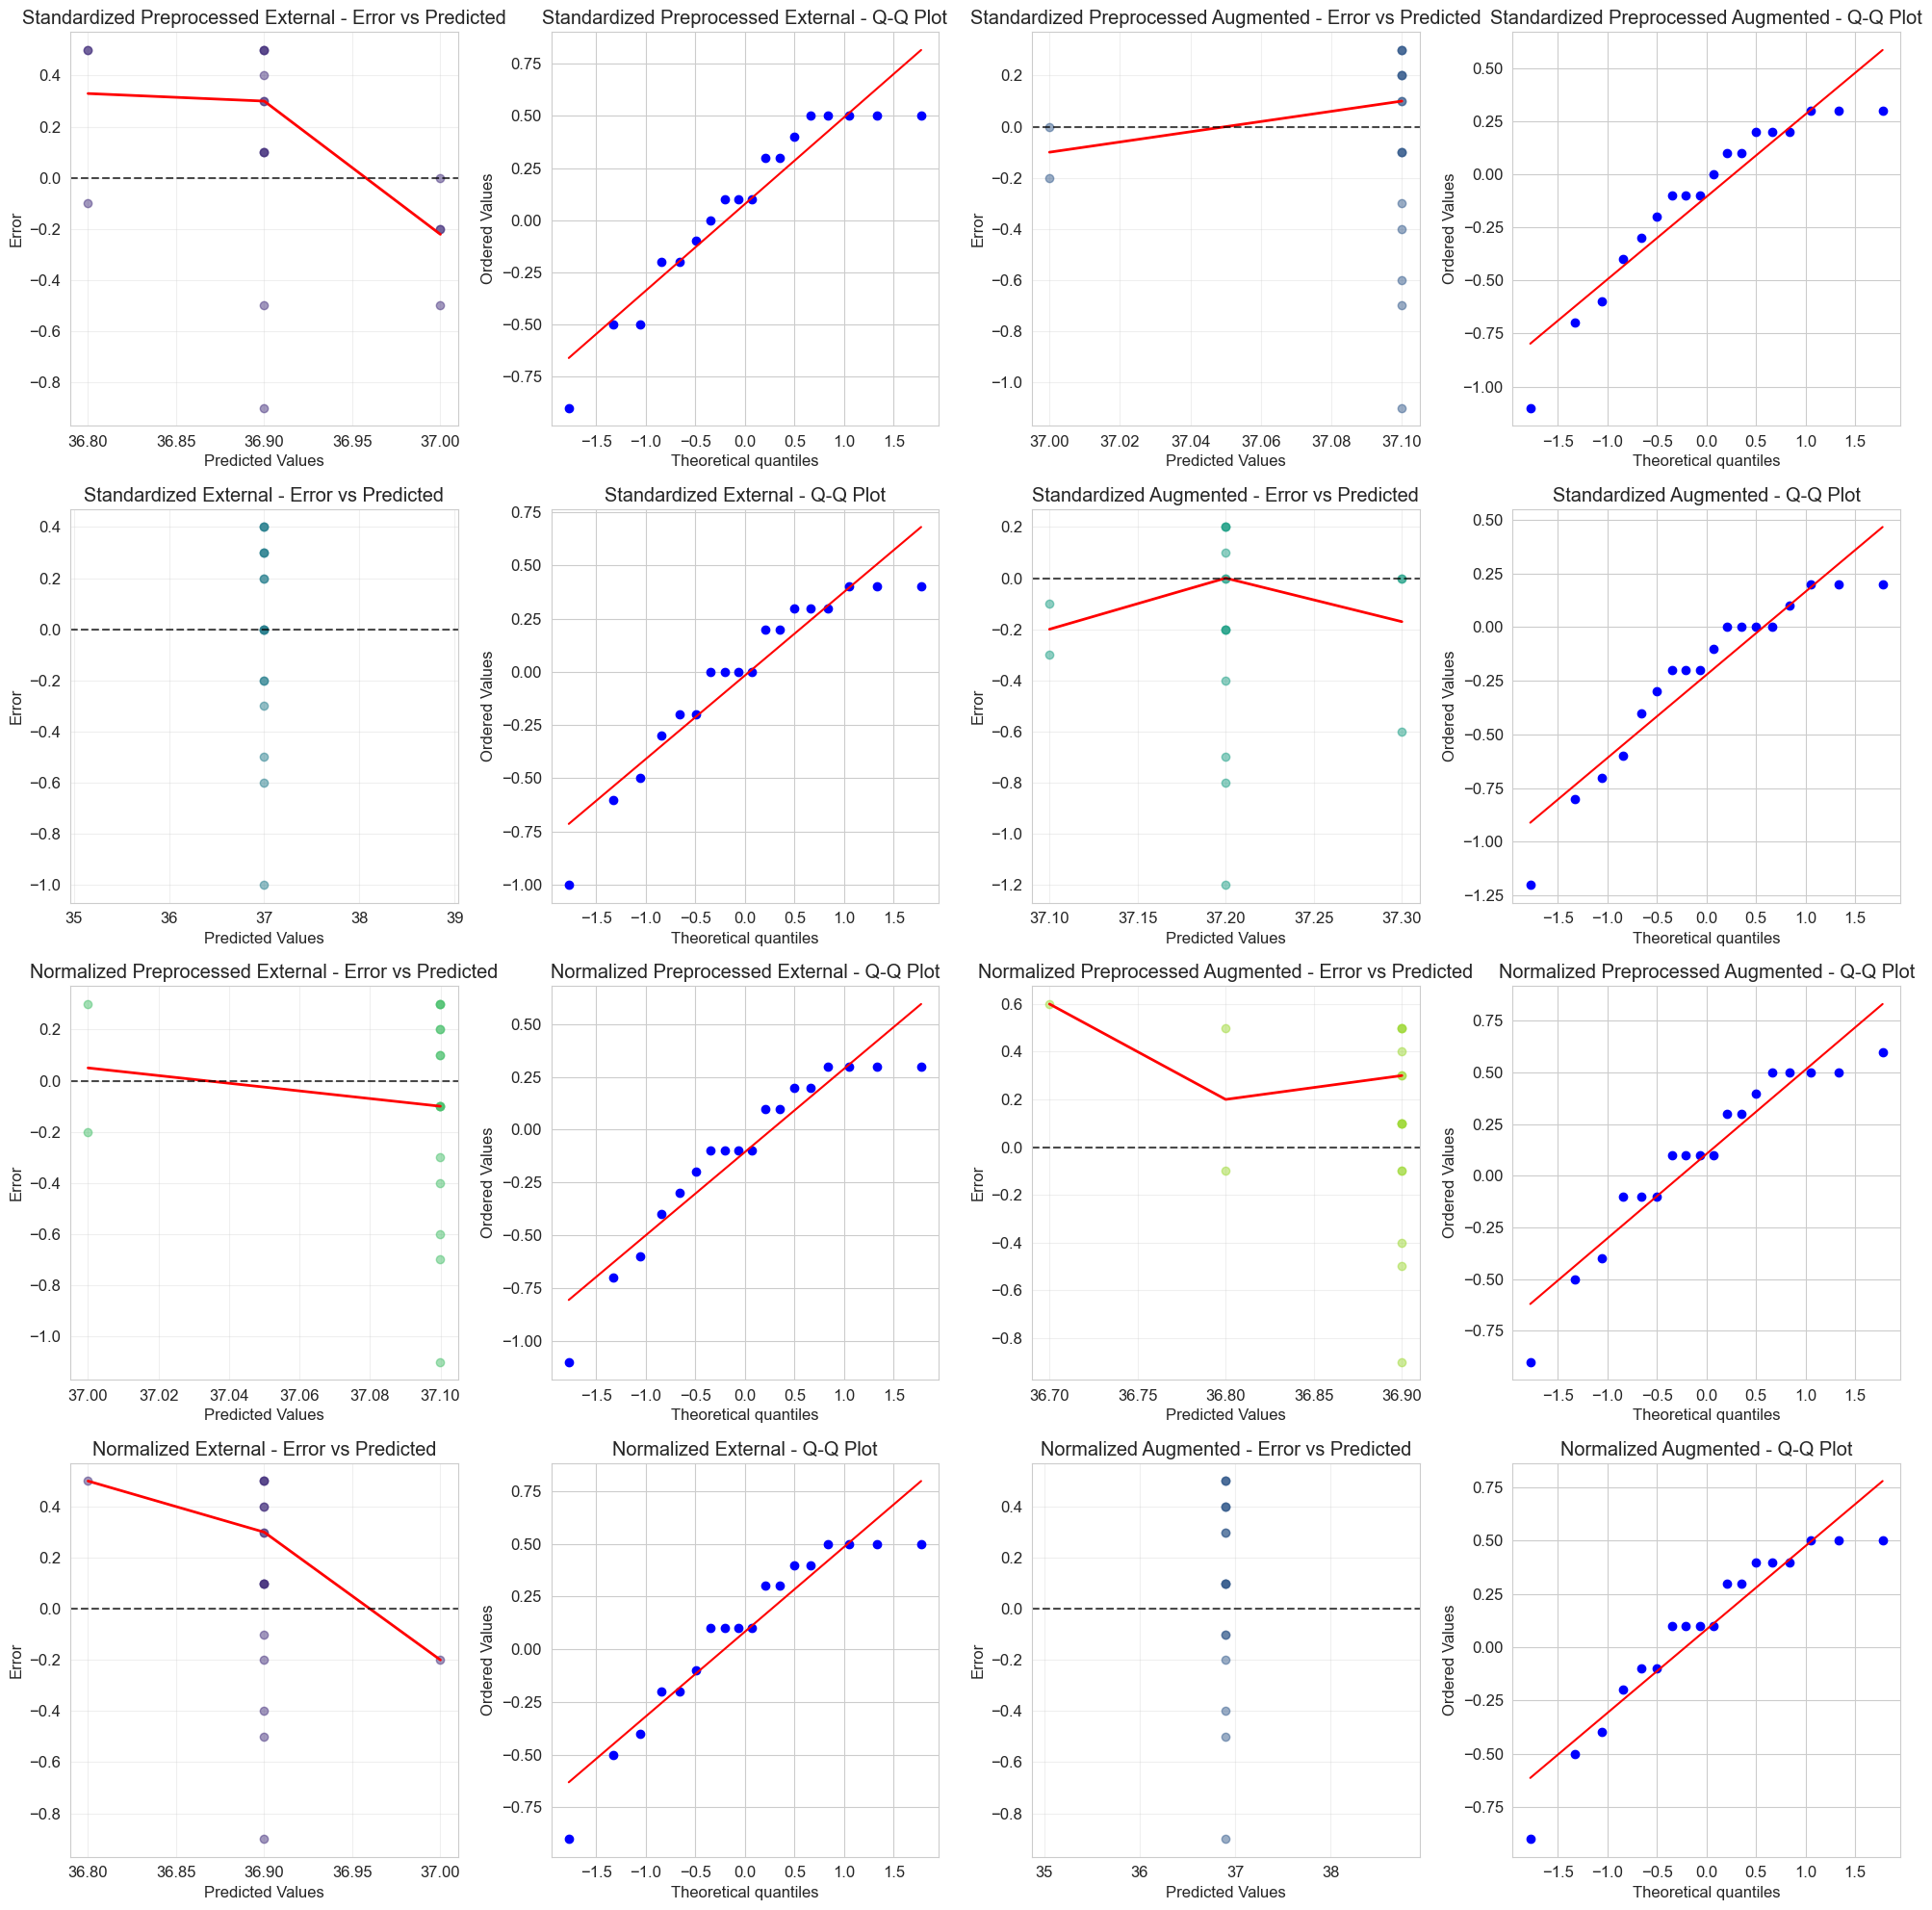

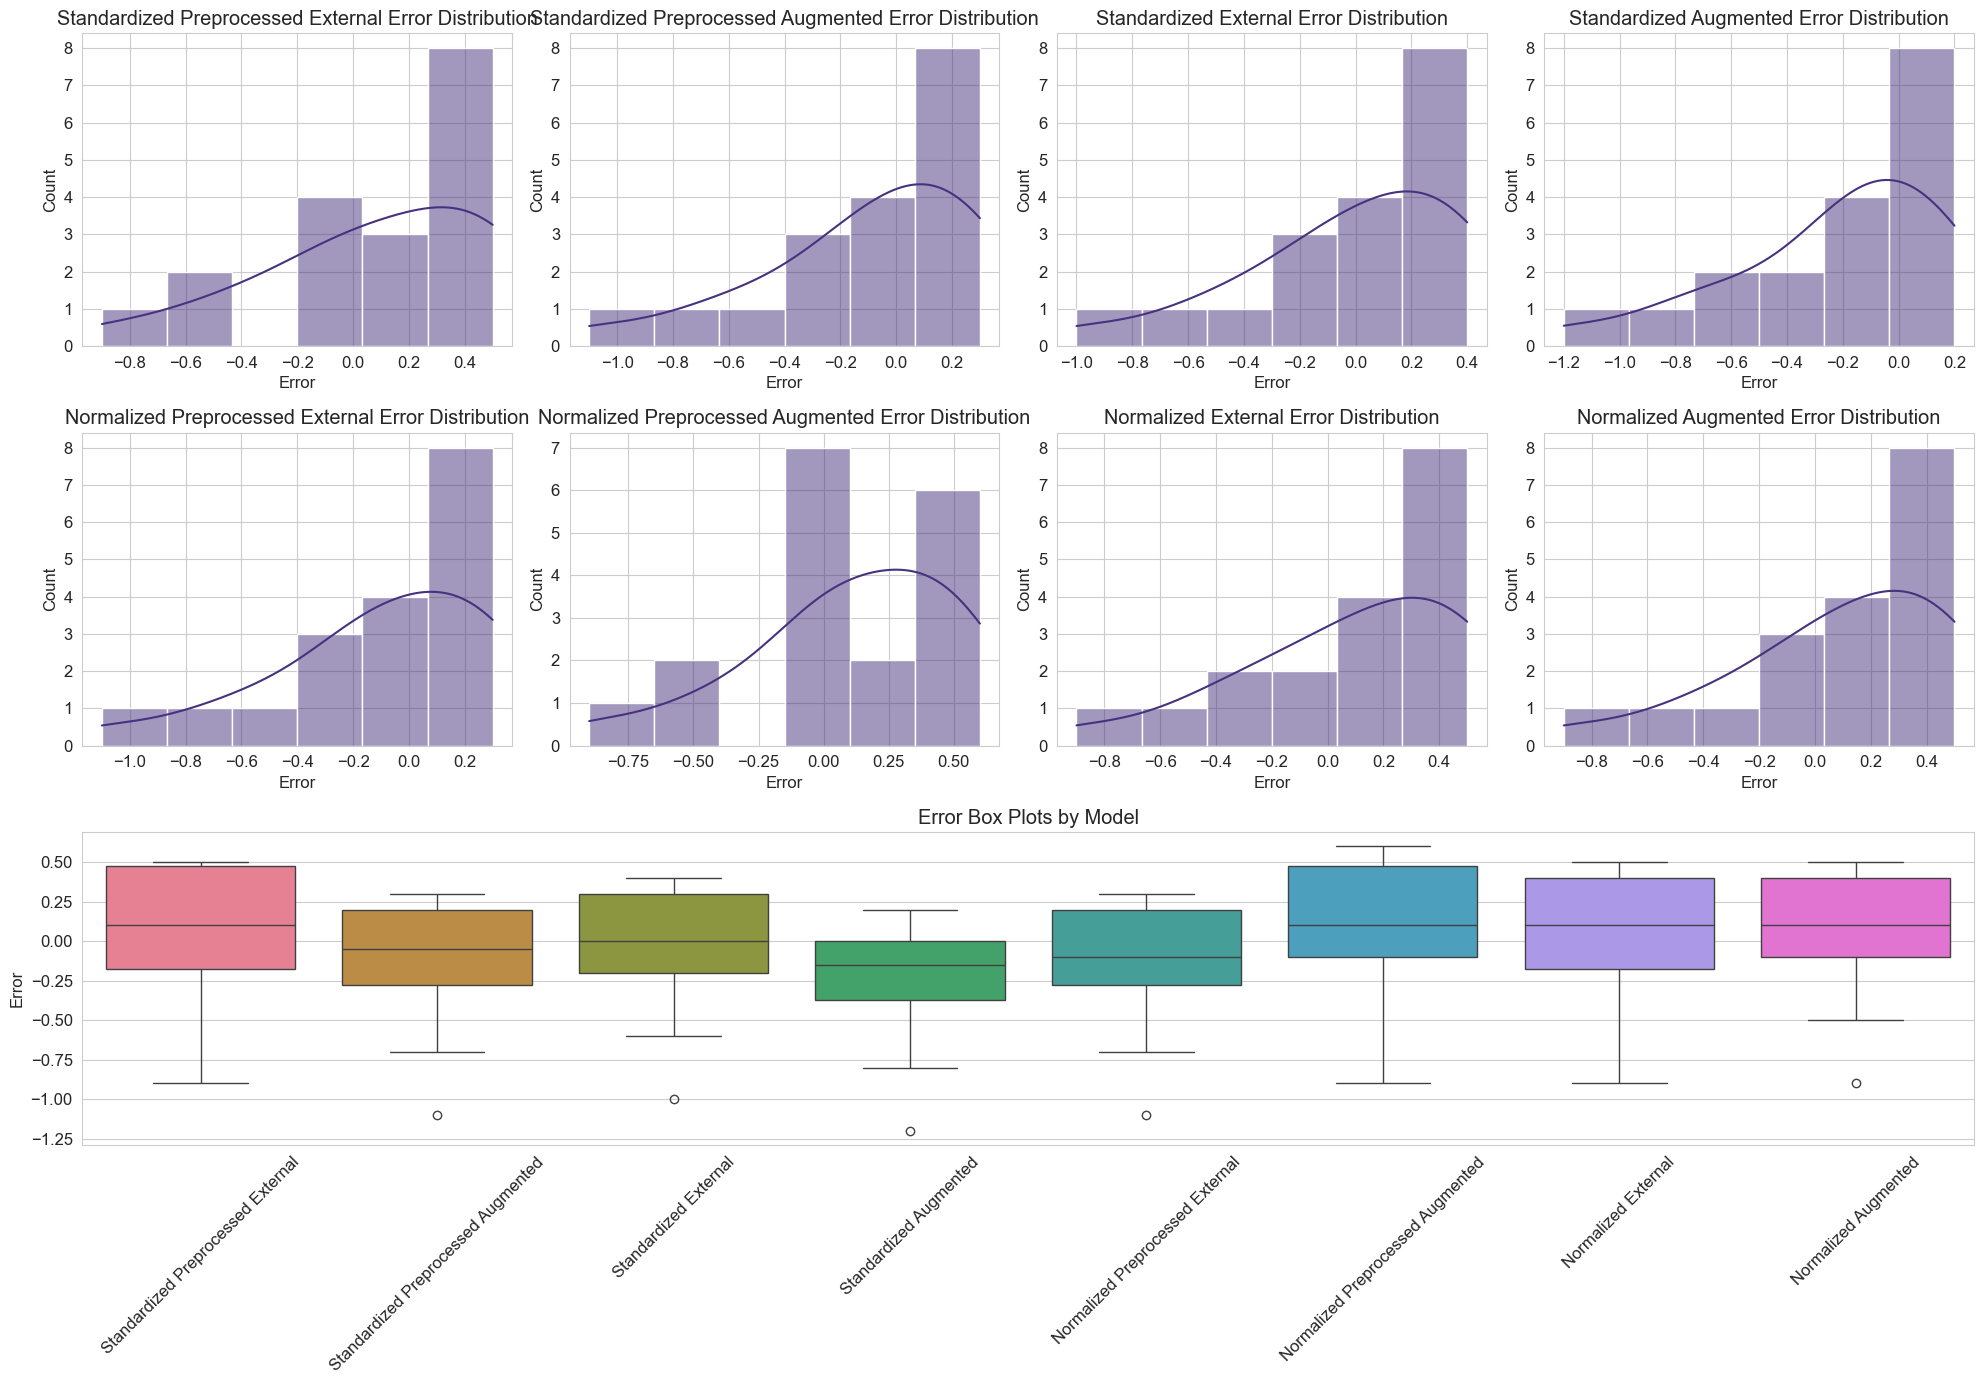

In [10]:
print("\nComparing models:")
dtodmetrics, dtodstats, dtodoverallstats, dtodnormality, dtodhomoscedasticity, dtodassumption, dtodstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'default_activity') & (test_data['Rc'] == 'default')], ['default_pa', 'default'], 'Tc', to_sort=False, plot=True)

### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.461736 0.350098 0.213200 -0.572786
Standardized Preprocessed Augmented 0.462783 0.356459 0.214168 -0.579928
              Standardized External 0.395139 0.328791 0.156135 -0.151814
             Standardized Augmented 0.627383 0.517802 0.393610 -1.903679
   Normalized Preprocessed External 0.443978 0.356482 0.197116 -0.454136
  Normalized Preprocessed Augmented 0.345900 0.301195 0.119647  0.117359
                Normalized External 0.488084 0.377627 0.238226 -0.757405
               Normalized Augmented 0.421360 0.323546 0.177544 -0.309754

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.373558 0.319392 0.139546 -0.108974
Standardized Preprocessed Augmented 0.374617 0.319220 0.140338 -0.115270
              Stand

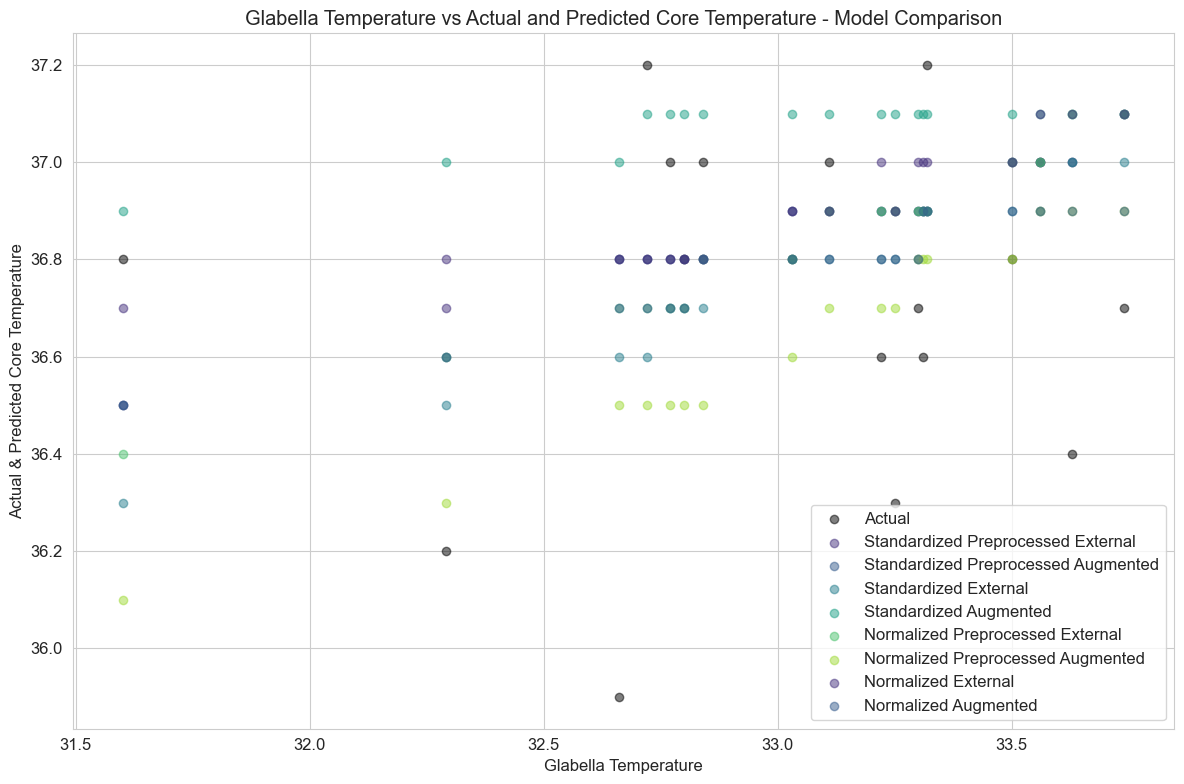

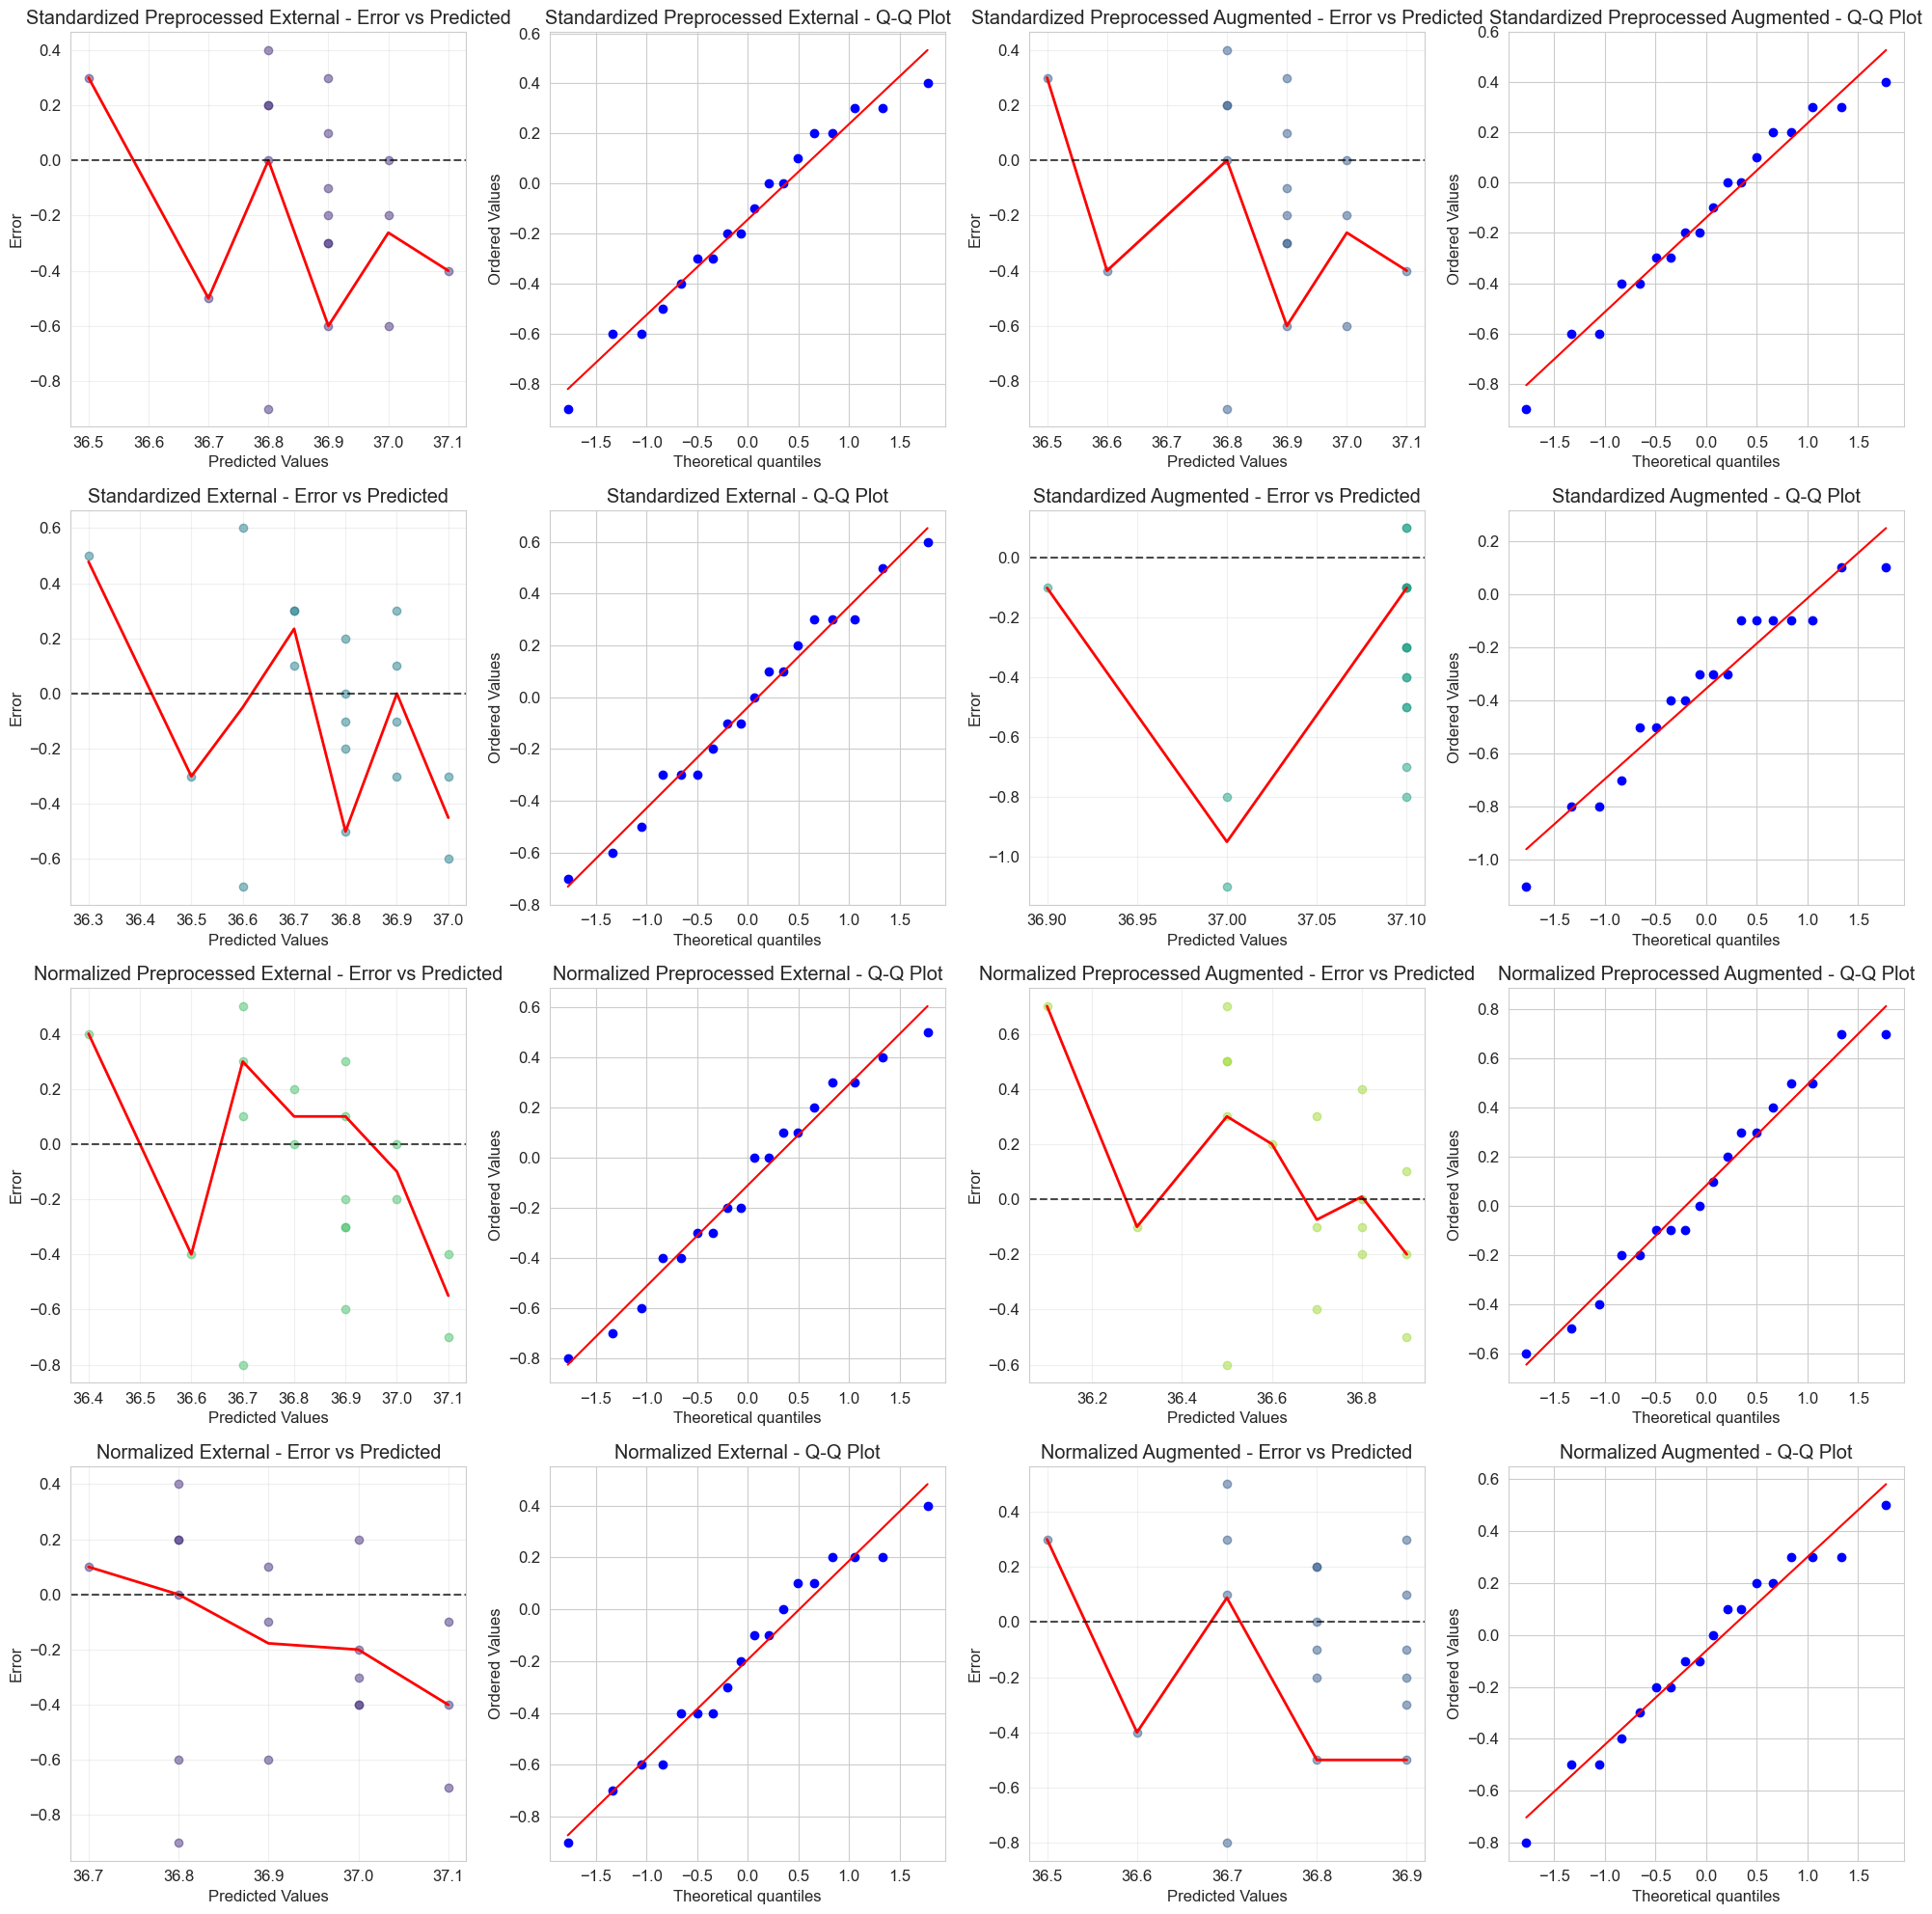

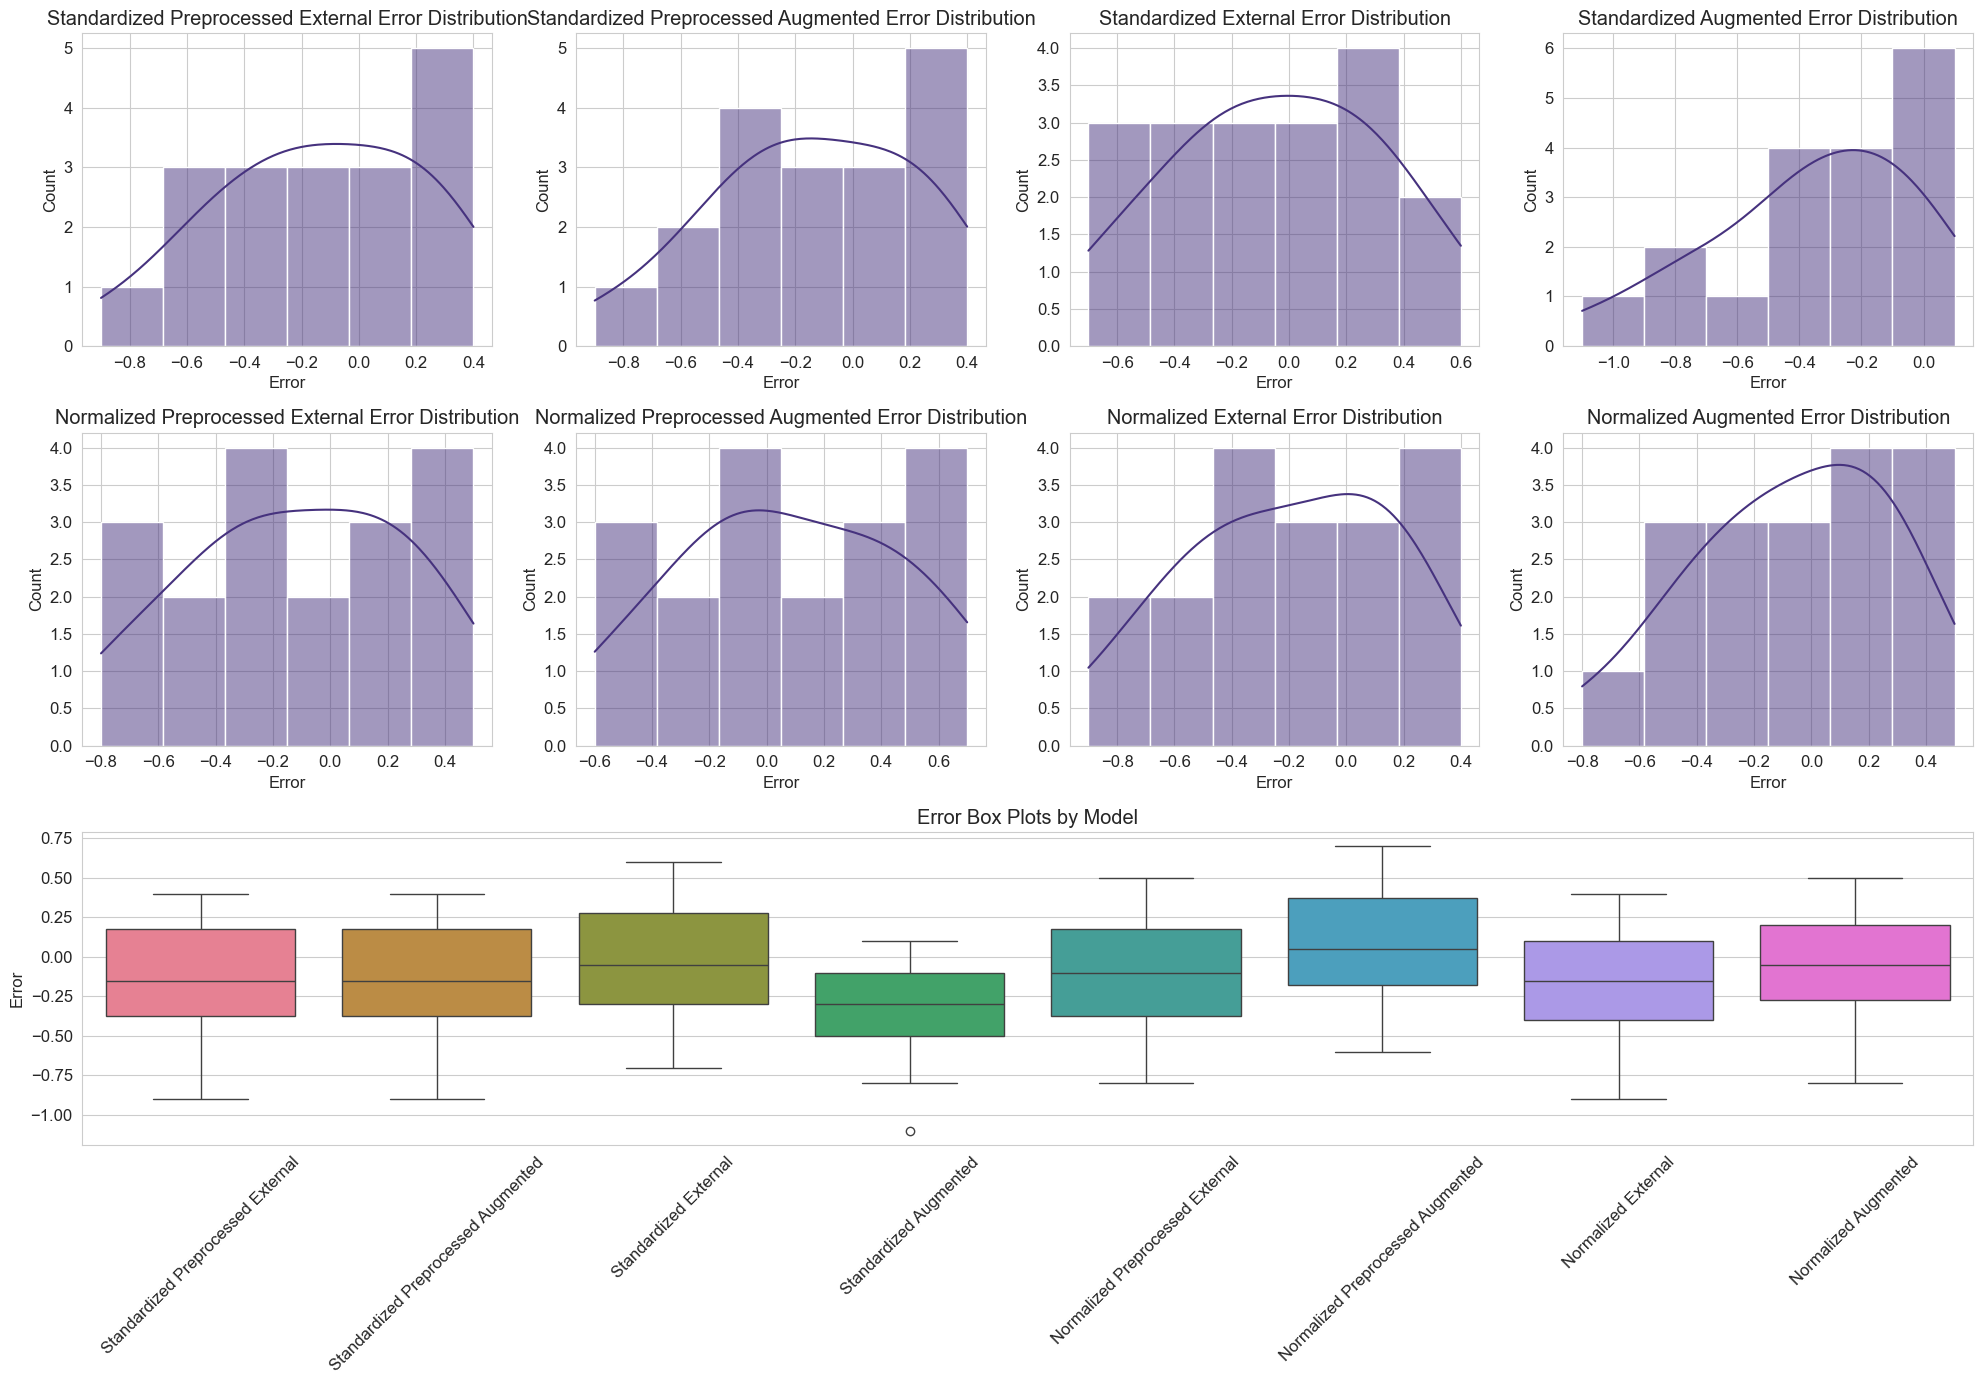

In [11]:
print("\nComparing models:")
dtocmetrics, dtocstats, dtocoverallstats, dtocnormality, dtochomoscedasticity, dtocassumption, dtocstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'default_activity') & (test_data['Rc'] == 'cooled')], ['default_pa', 'cooled'], 'Tc', to_sort=False, plot=True)

## Rigorous

### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.358882 0.289588 0.128796 -0.016814
Standardized Preprocessed Augmented 0.504358 0.408352 0.254377 -1.008243
              Standardized External 0.477880 0.396648 0.228369 -0.802914
             Standardized Augmented 0.629898 0.530530 0.396771 -2.132404
   Normalized Preprocessed External 0.442089 0.368432 0.195442 -0.542966
  Normalized Preprocessed Augmented 0.428039 0.377894 0.183218 -0.446456
                Normalized External 0.374737 0.330661 0.140428 -0.108643
               Normalized Augmented 0.416586 0.330643 0.173544 -0.370082

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.383998 0.316131 0.147455  0.052077
Standardized Preprocessed Augmented 0.528169 0.458402 0.278963 -0.793333
              Stand

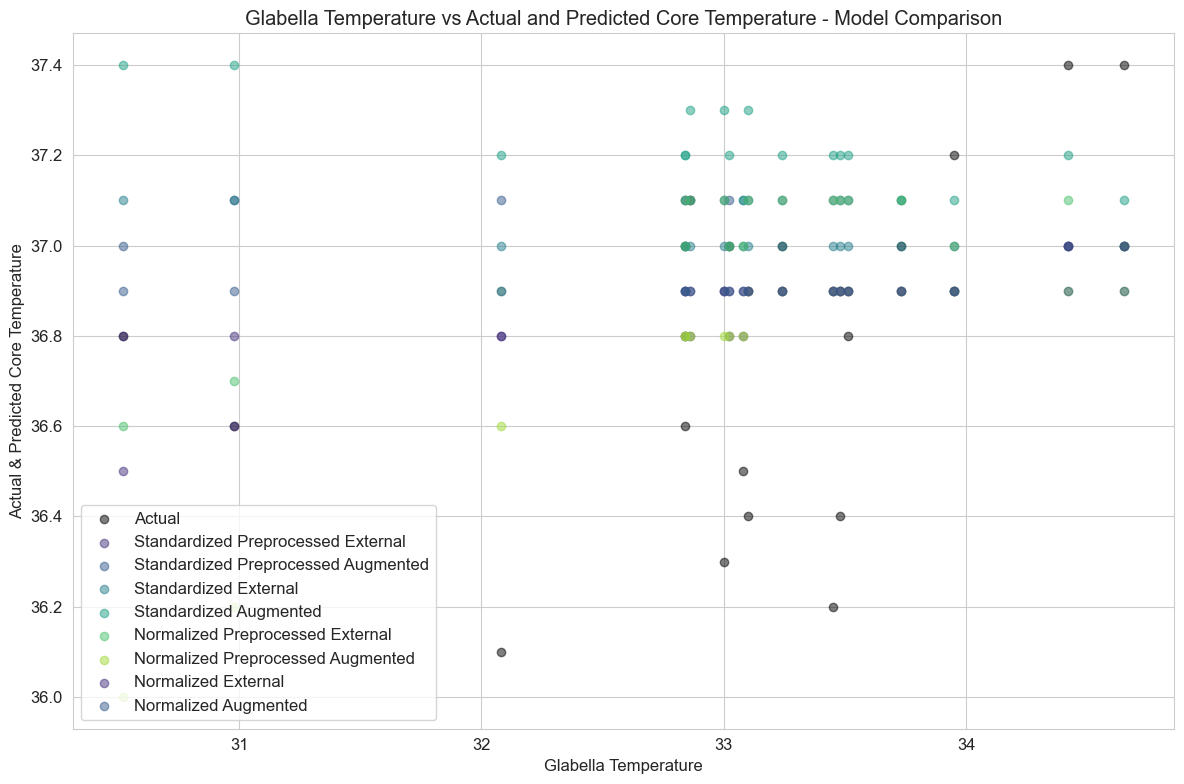

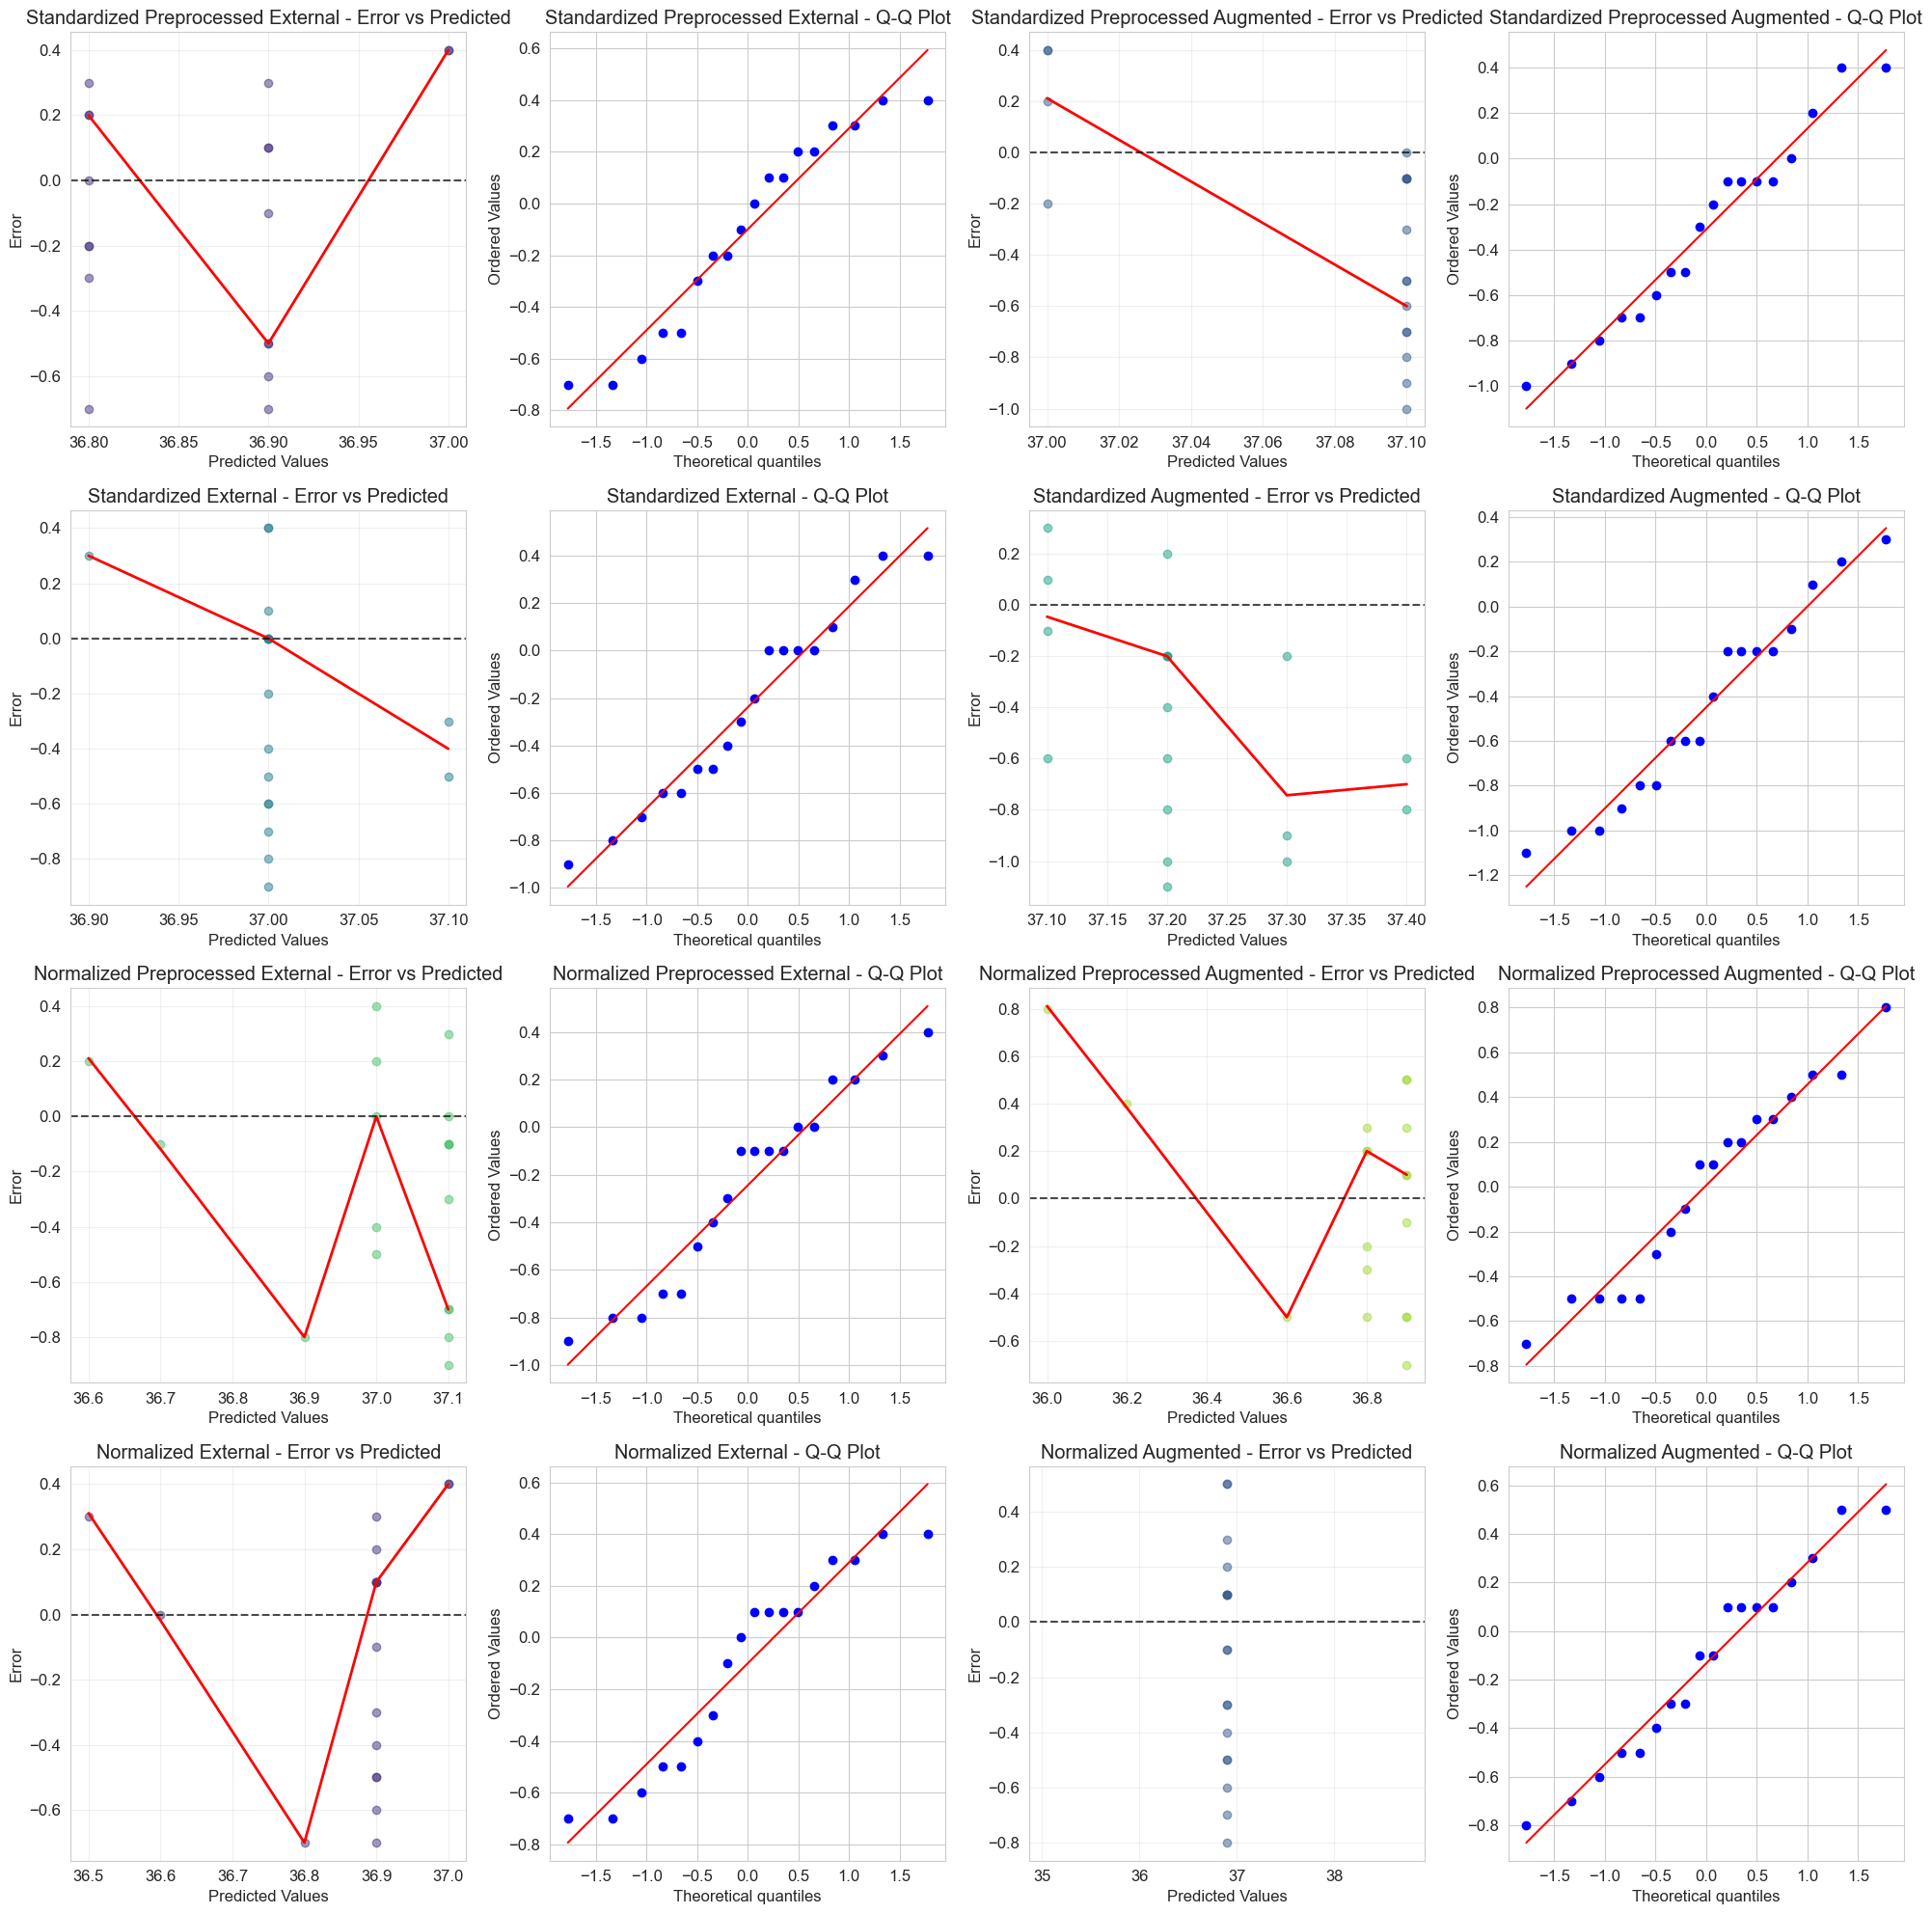

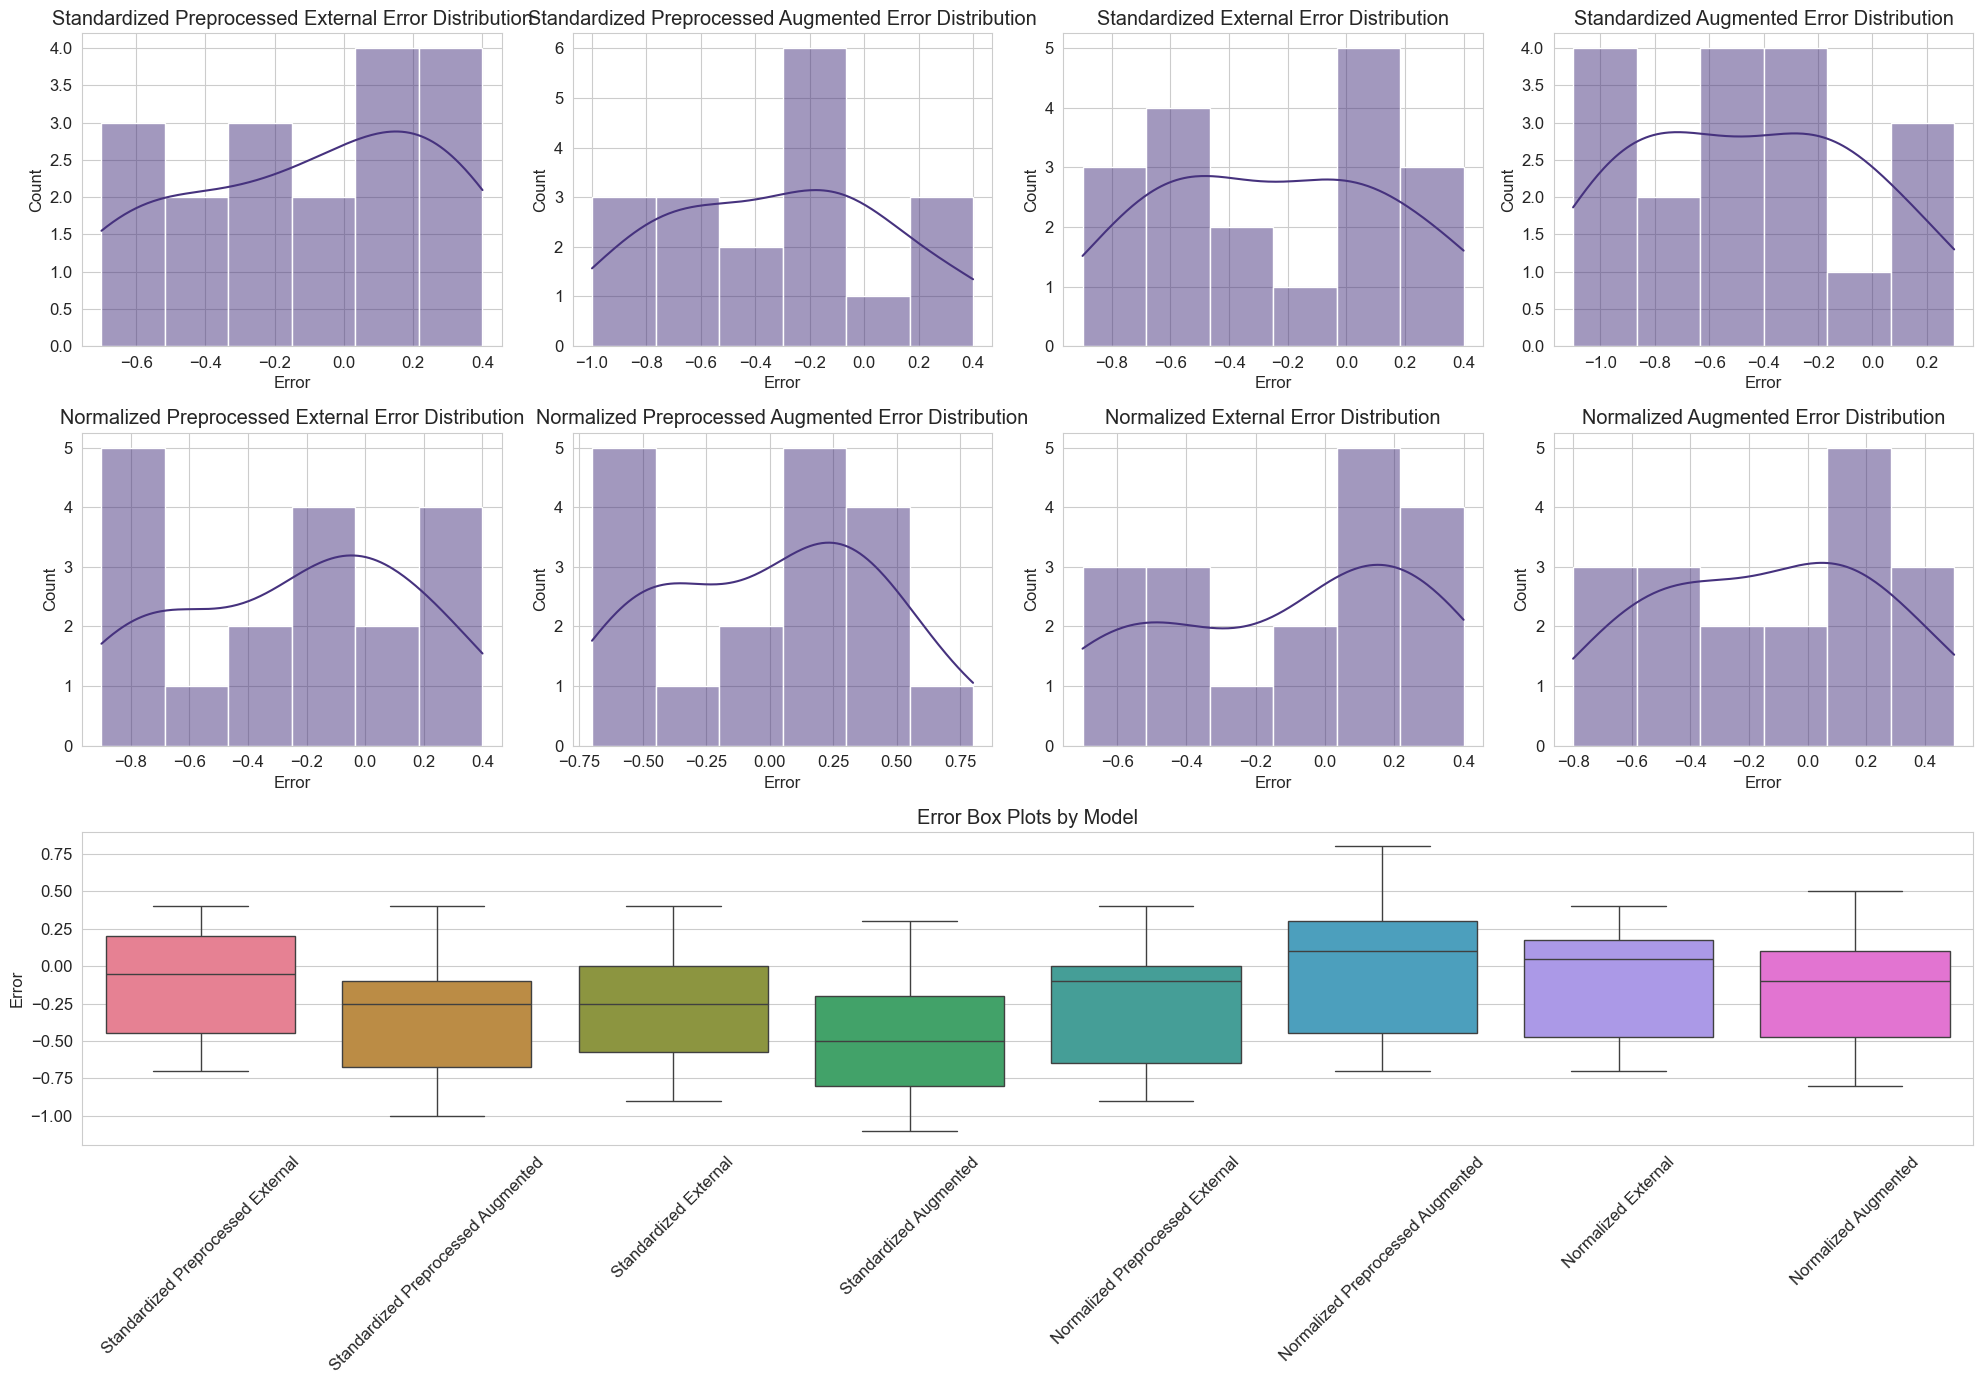

In [12]:

print("\nComparing models:")
rtodmetrics, rtodstats, rtodoverallstats, rtodnormality, rtodhomoscedasticity, rtodassumption, rtodstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'default')], ['rigorous_pa', 'default'], 'Tc', to_sort=False, plot=True)

### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.686207 0.564807 0.470880 -0.210835
Standardized Preprocessed Augmented 0.679698 0.560333 0.461990 -0.187974
              Standardized External 0.681551 0.587616 0.464511 -0.194457
             Standardized Augmented 0.795589 0.612013 0.632962 -0.627617
   Normalized Preprocessed External 0.684889 0.574412 0.469073 -0.206188
  Normalized Preprocessed Augmented 0.771777 0.709455 0.595640 -0.531646
                Normalized External 0.697422 0.548746 0.486398 -0.250738
               Normalized Augmented 0.669565 0.555858 0.448317 -0.152814

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.657722 0.580509 0.432598  0.016823
Standardized Preprocessed Augmented 0.655249 0.581145 0.429352  0.024201
              Stand

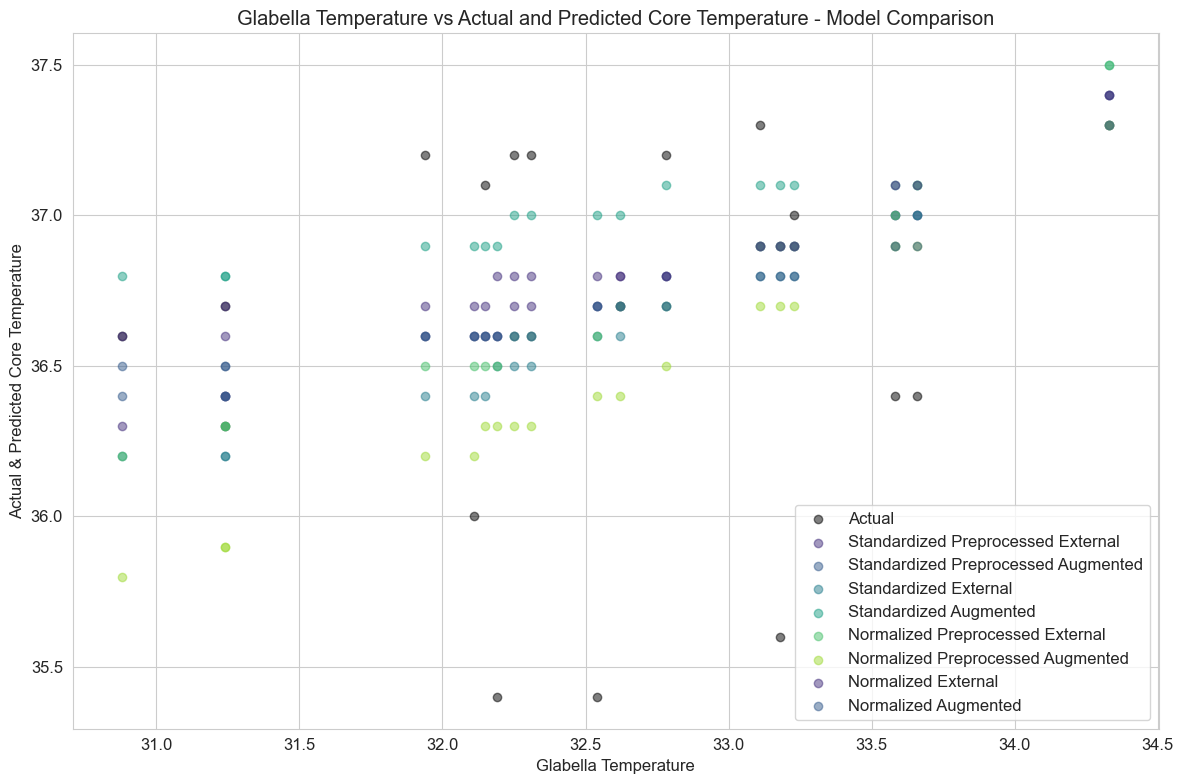

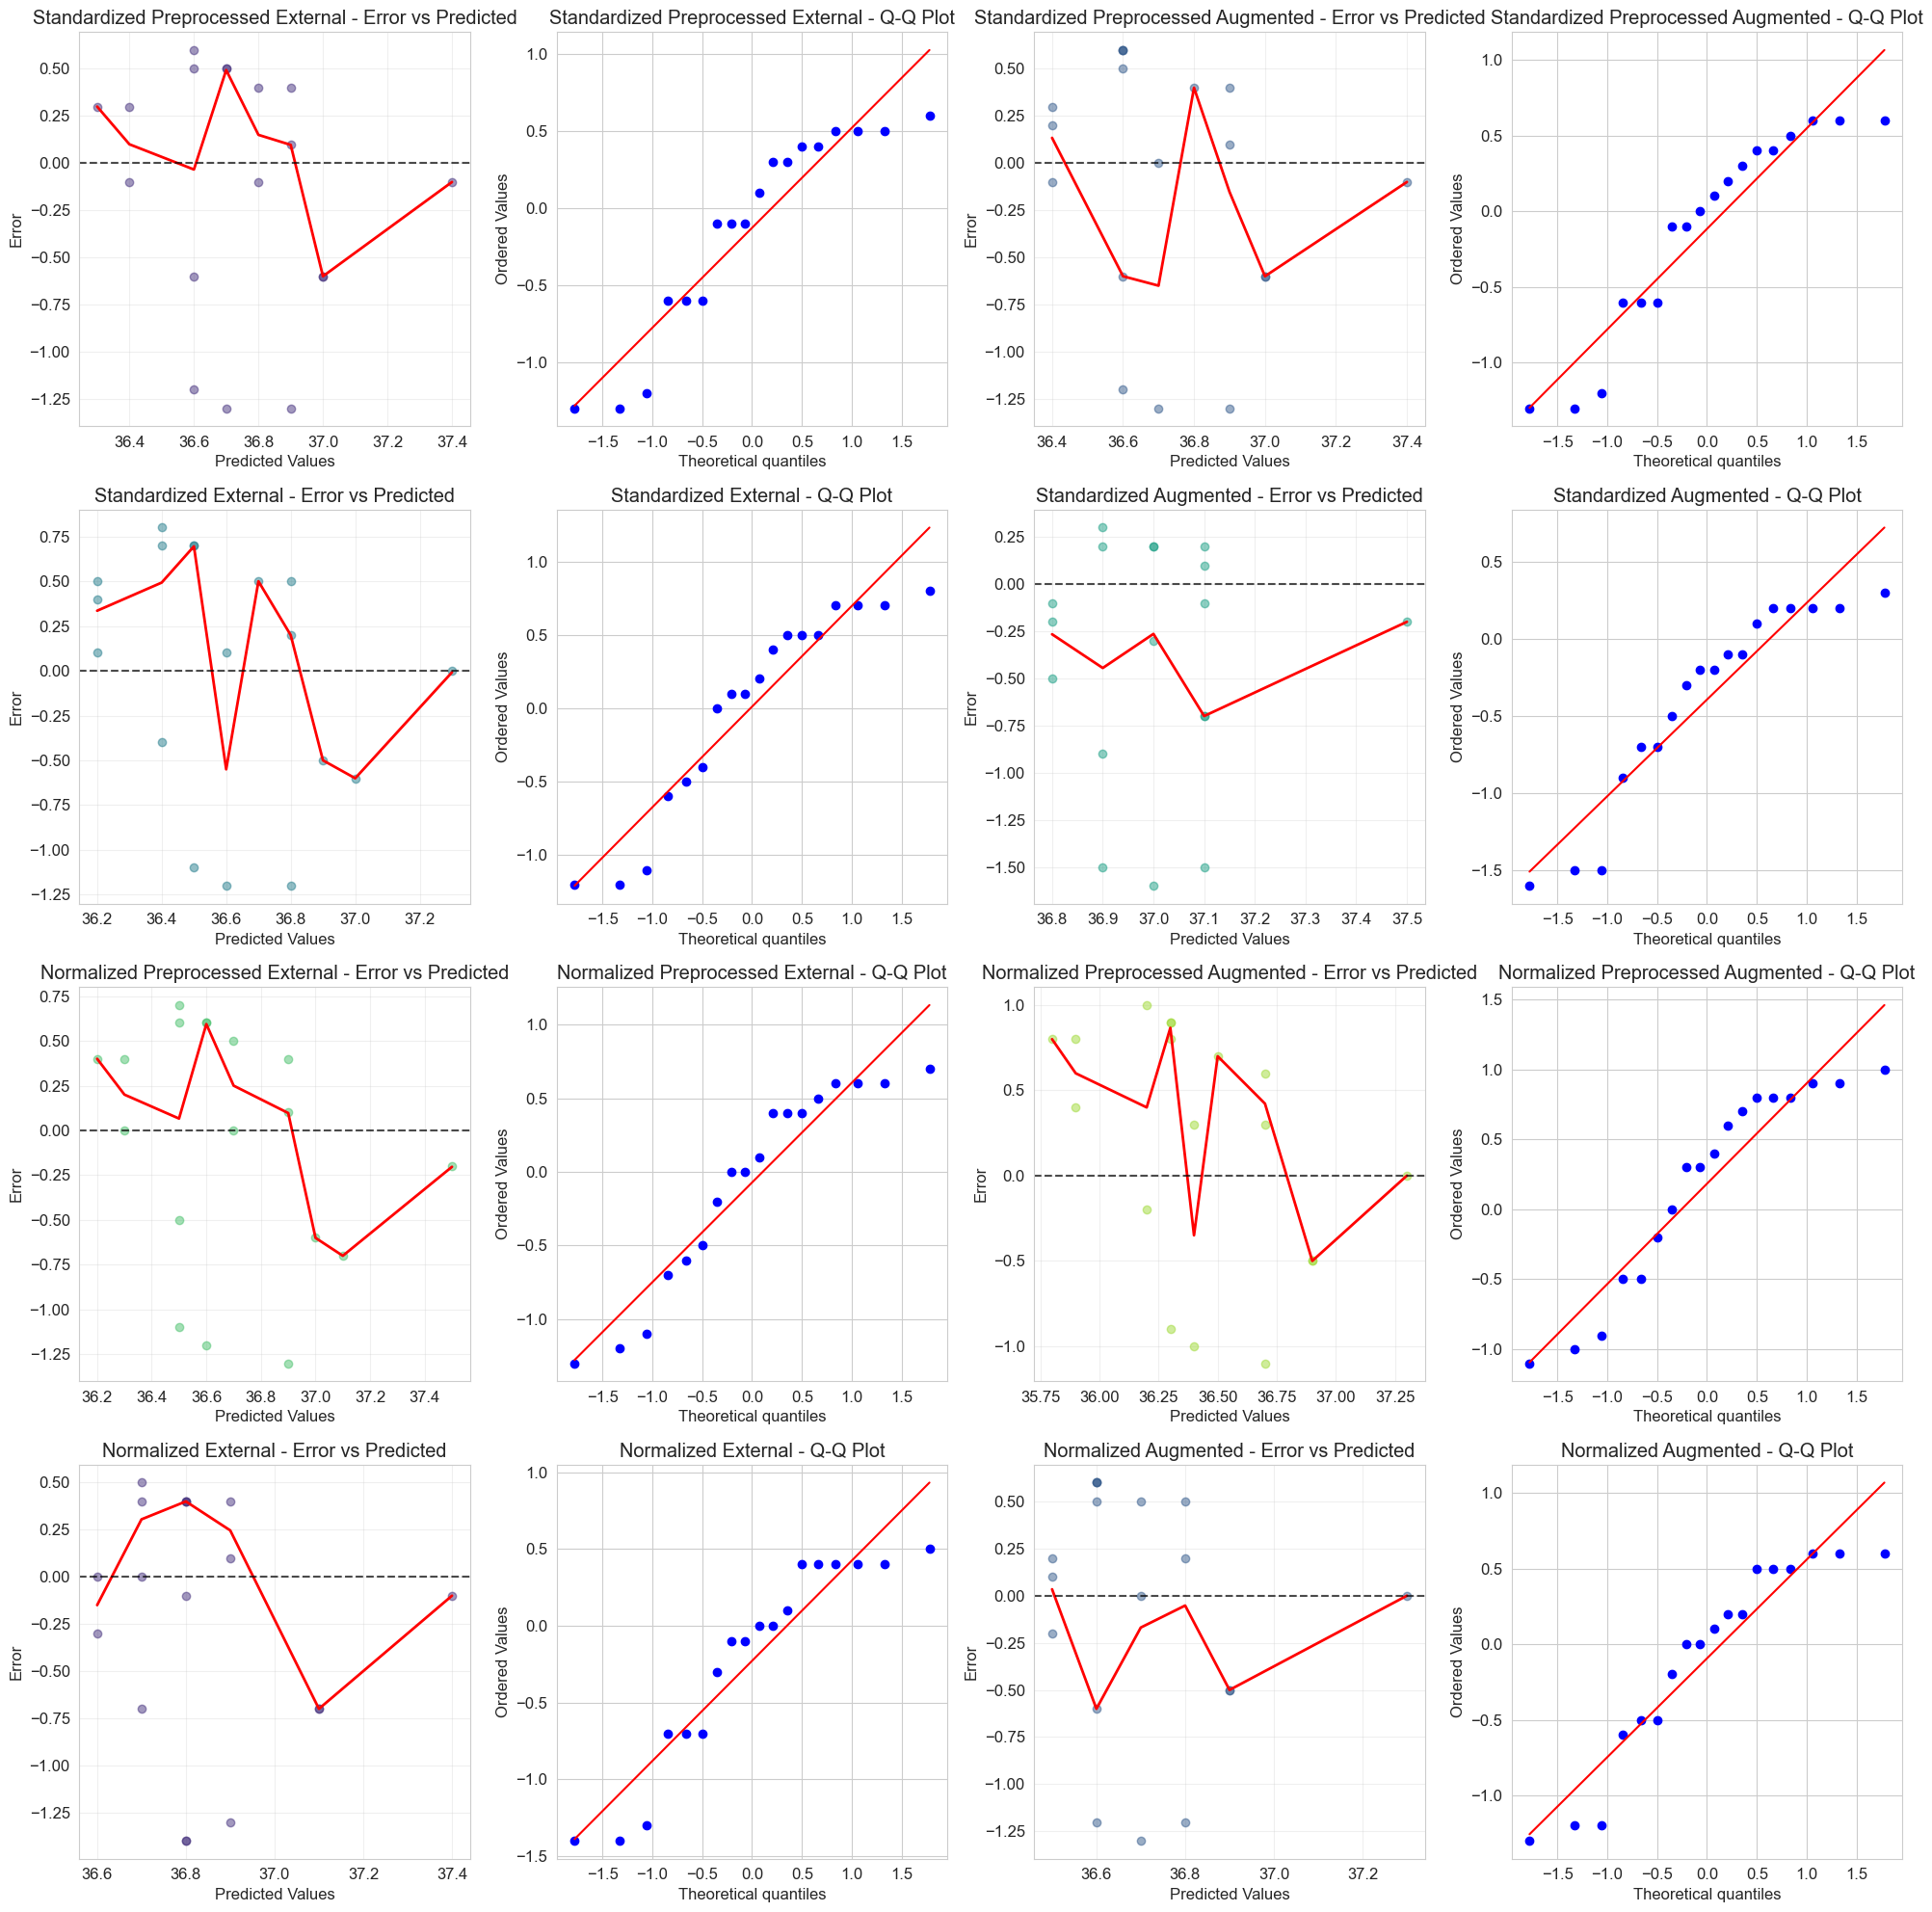

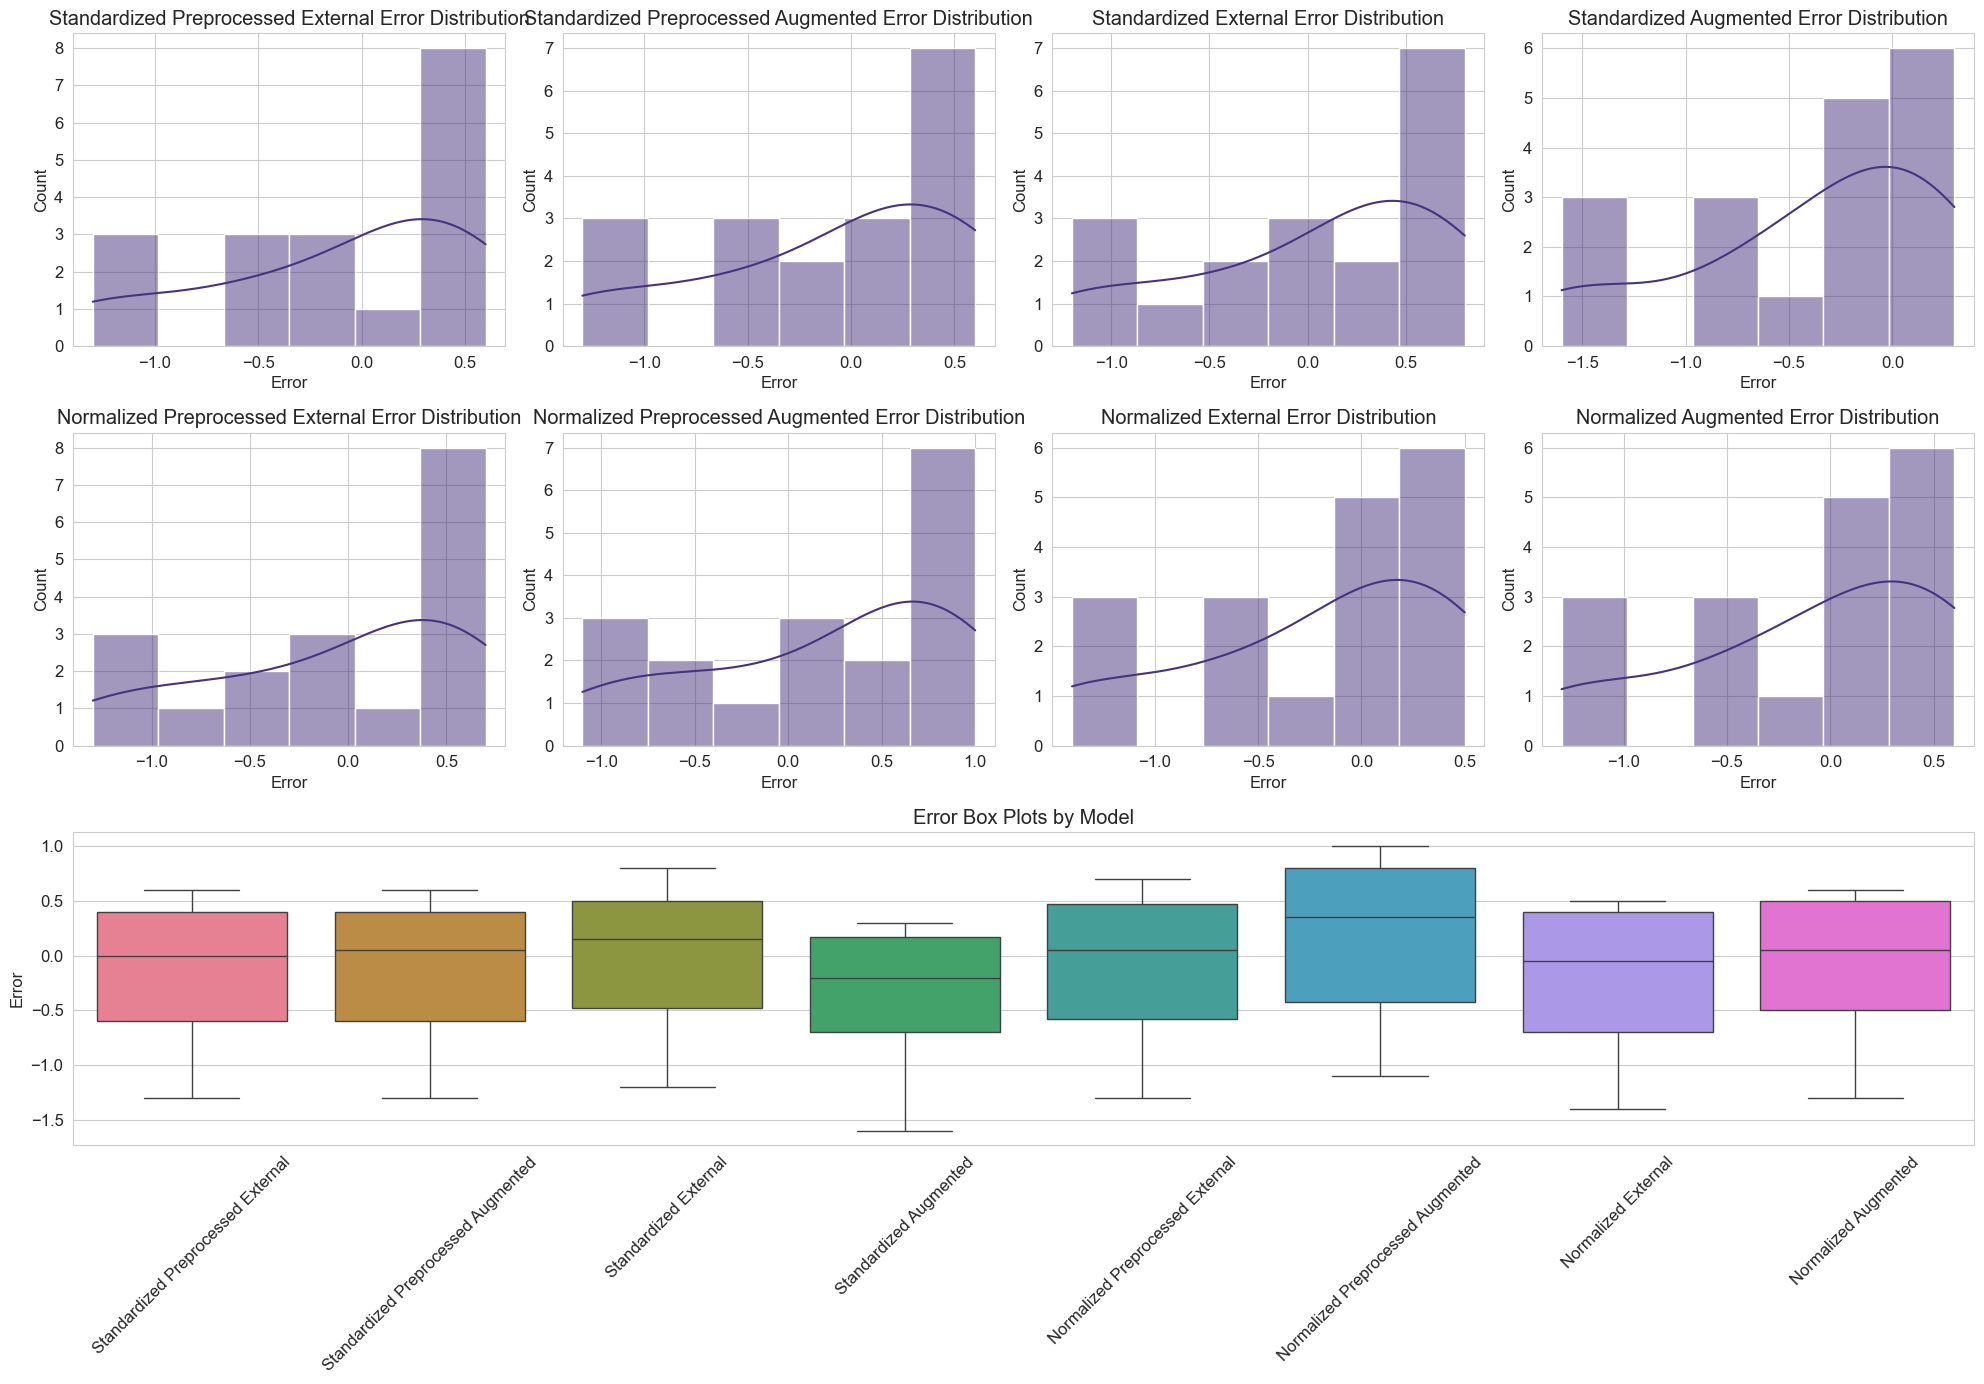

In [13]:
print("\nComparing models:")
rtocmetrics, rtocstats, rtocoverallstats, rtocnormality, rtochomoscedasticity, rtocassumption, rtocstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'rigorous_activity') & (test_data['Rc'] == 'cooled')], ['rigorous_pa', 'cooled'], 'Tc', to_sort=False, plot=True)

## Cooled

### Default Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.802557 0.506697 0.644098 -0.434873
Standardized Preprocessed Augmented 0.960516 0.692151 0.922591 -1.055277
              Standardized External 0.945106 0.652645 0.893226 -0.989859
             Standardized Augmented 1.109454 0.868085 1.230887 -1.742076
   Normalized Preprocessed External 0.821870 0.537809 0.675470 -0.504760
  Normalized Preprocessed Augmented 0.652823 0.466799 0.426177  0.050595
                Normalized External 0.774872 0.482532 0.600427 -0.337584
               Normalized Augmented 0.869277 0.580347 0.755643 -0.683364

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.732480 0.473253 0.536526 -0.291106
Standardized Preprocessed Augmented 0.877190 0.609105 0.769462 -0.851647
              Stand

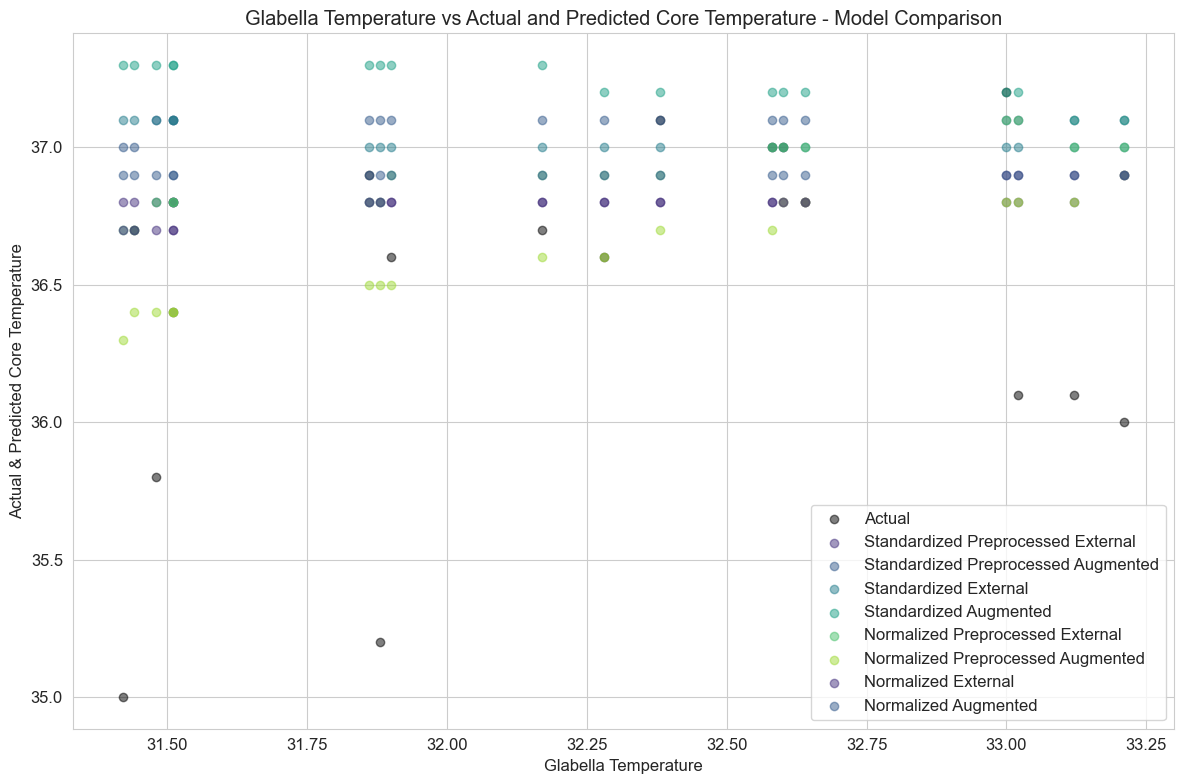

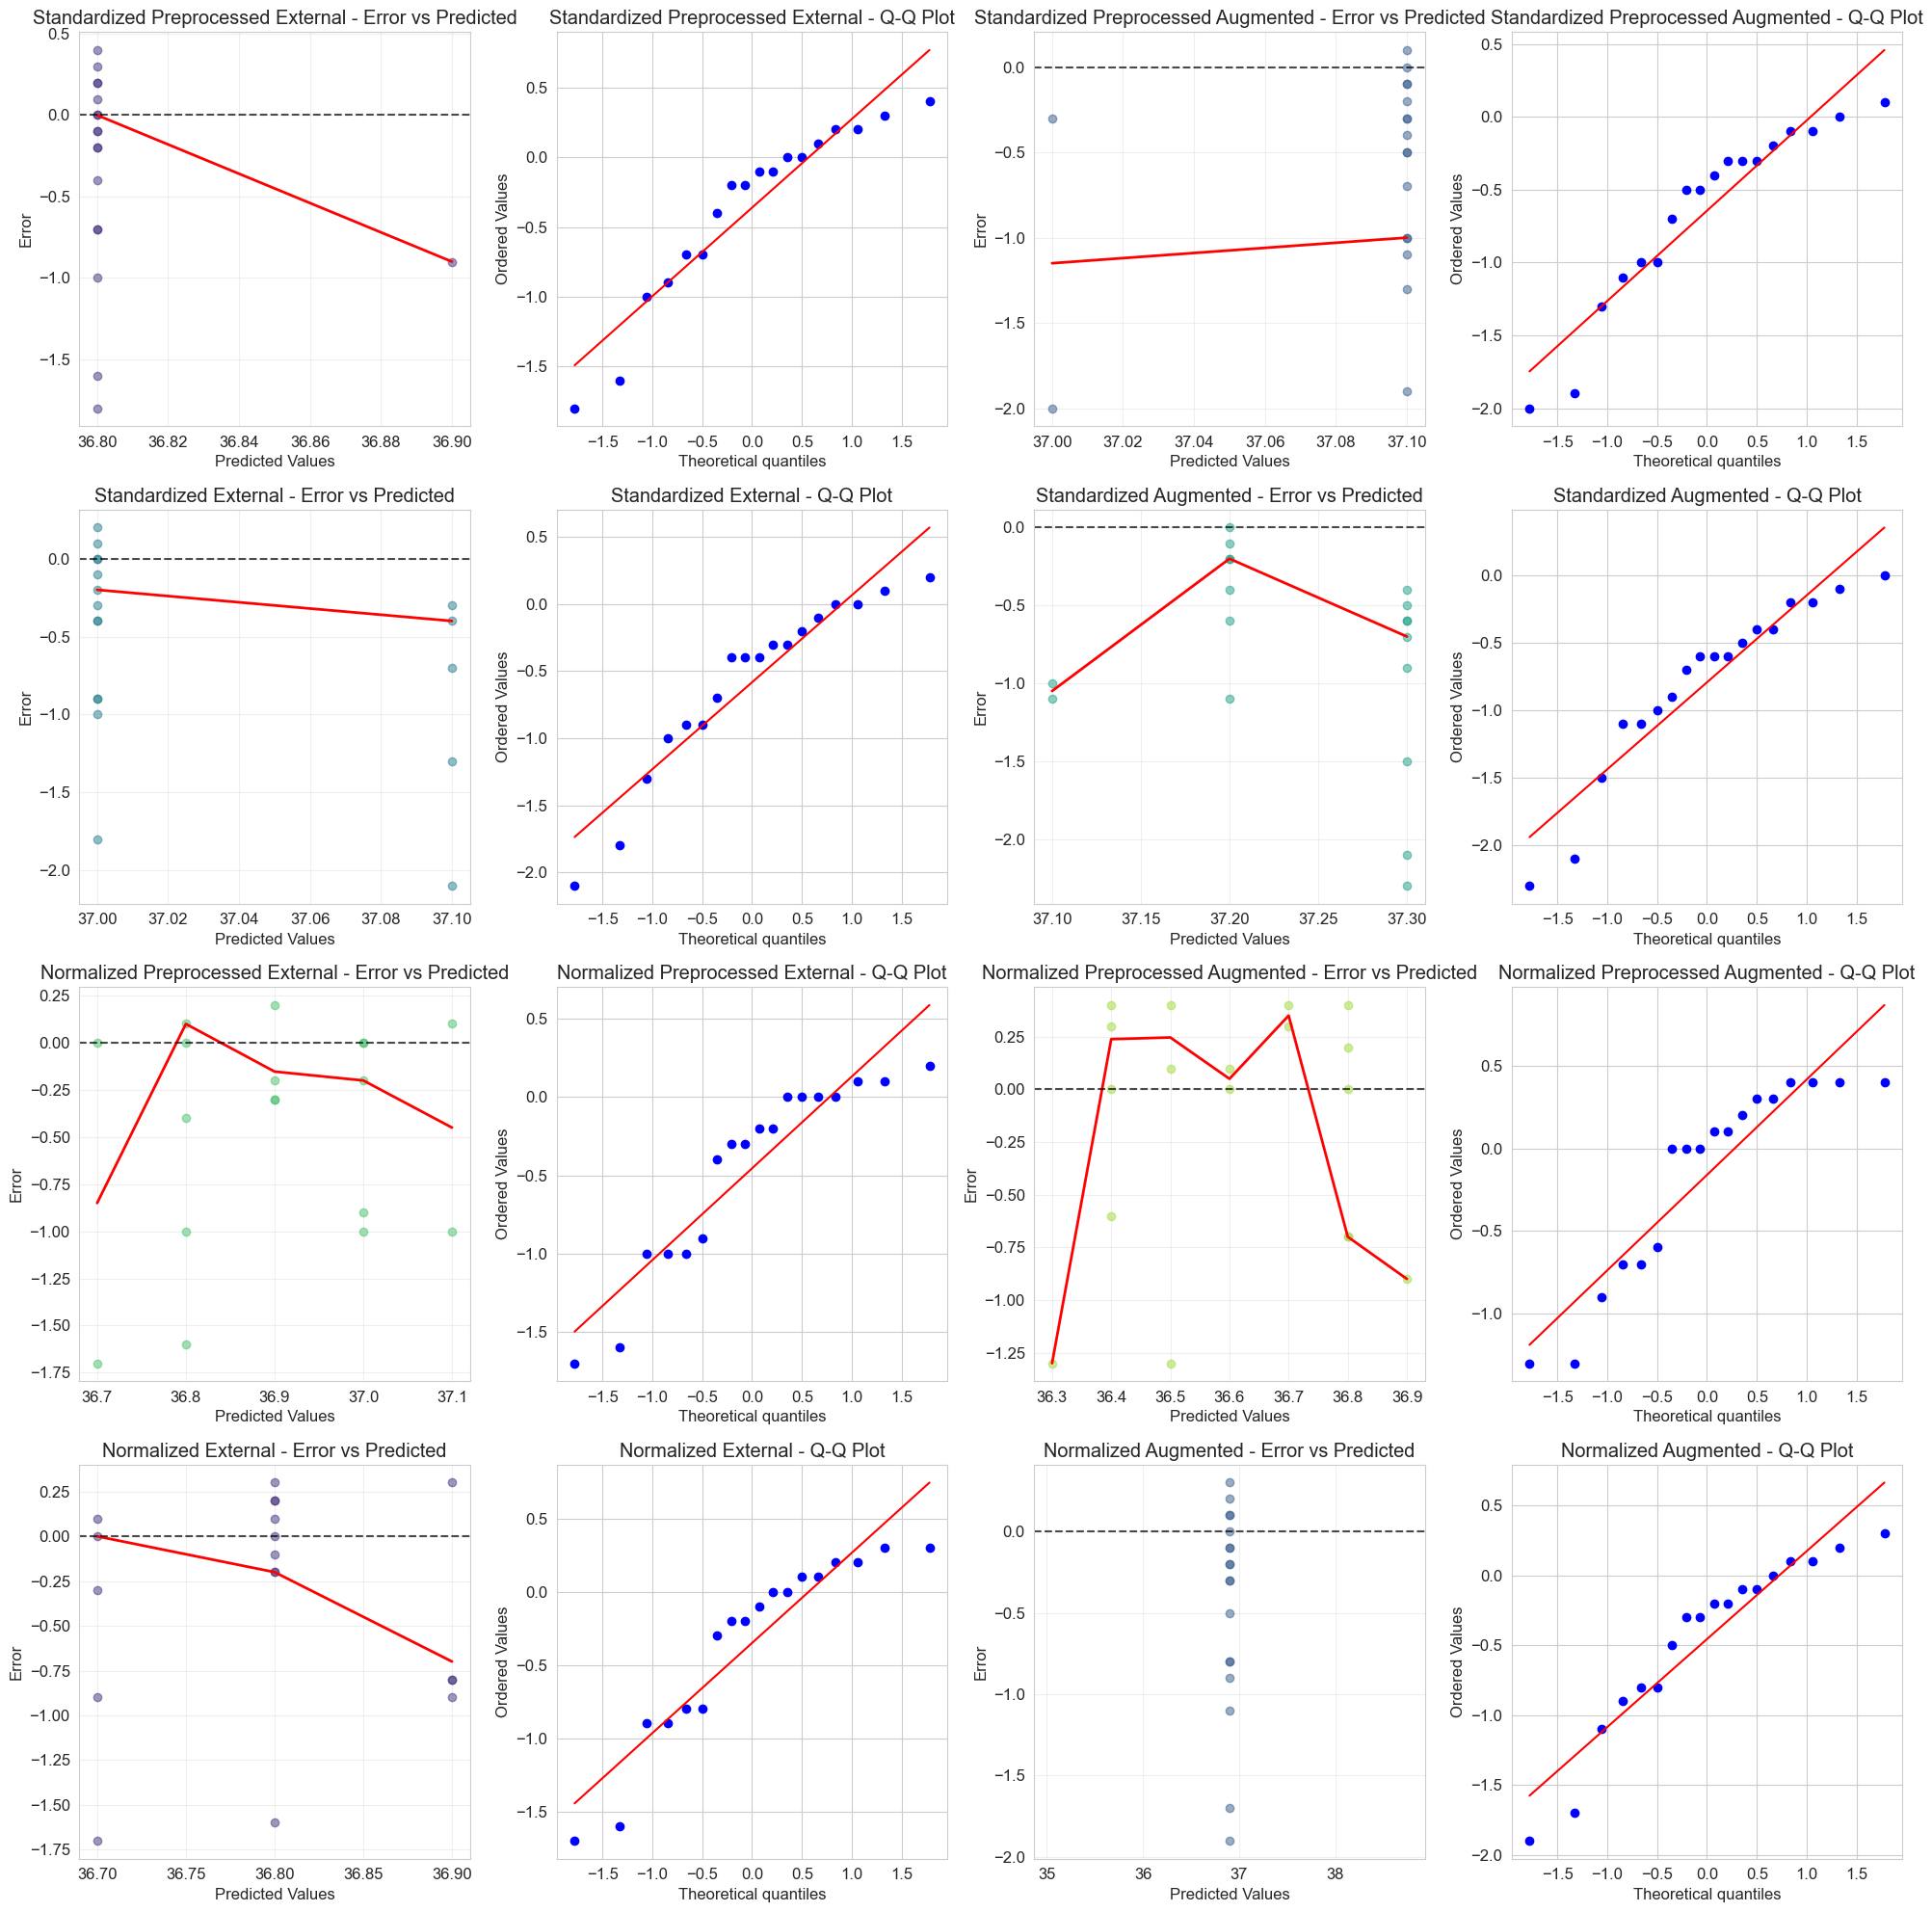

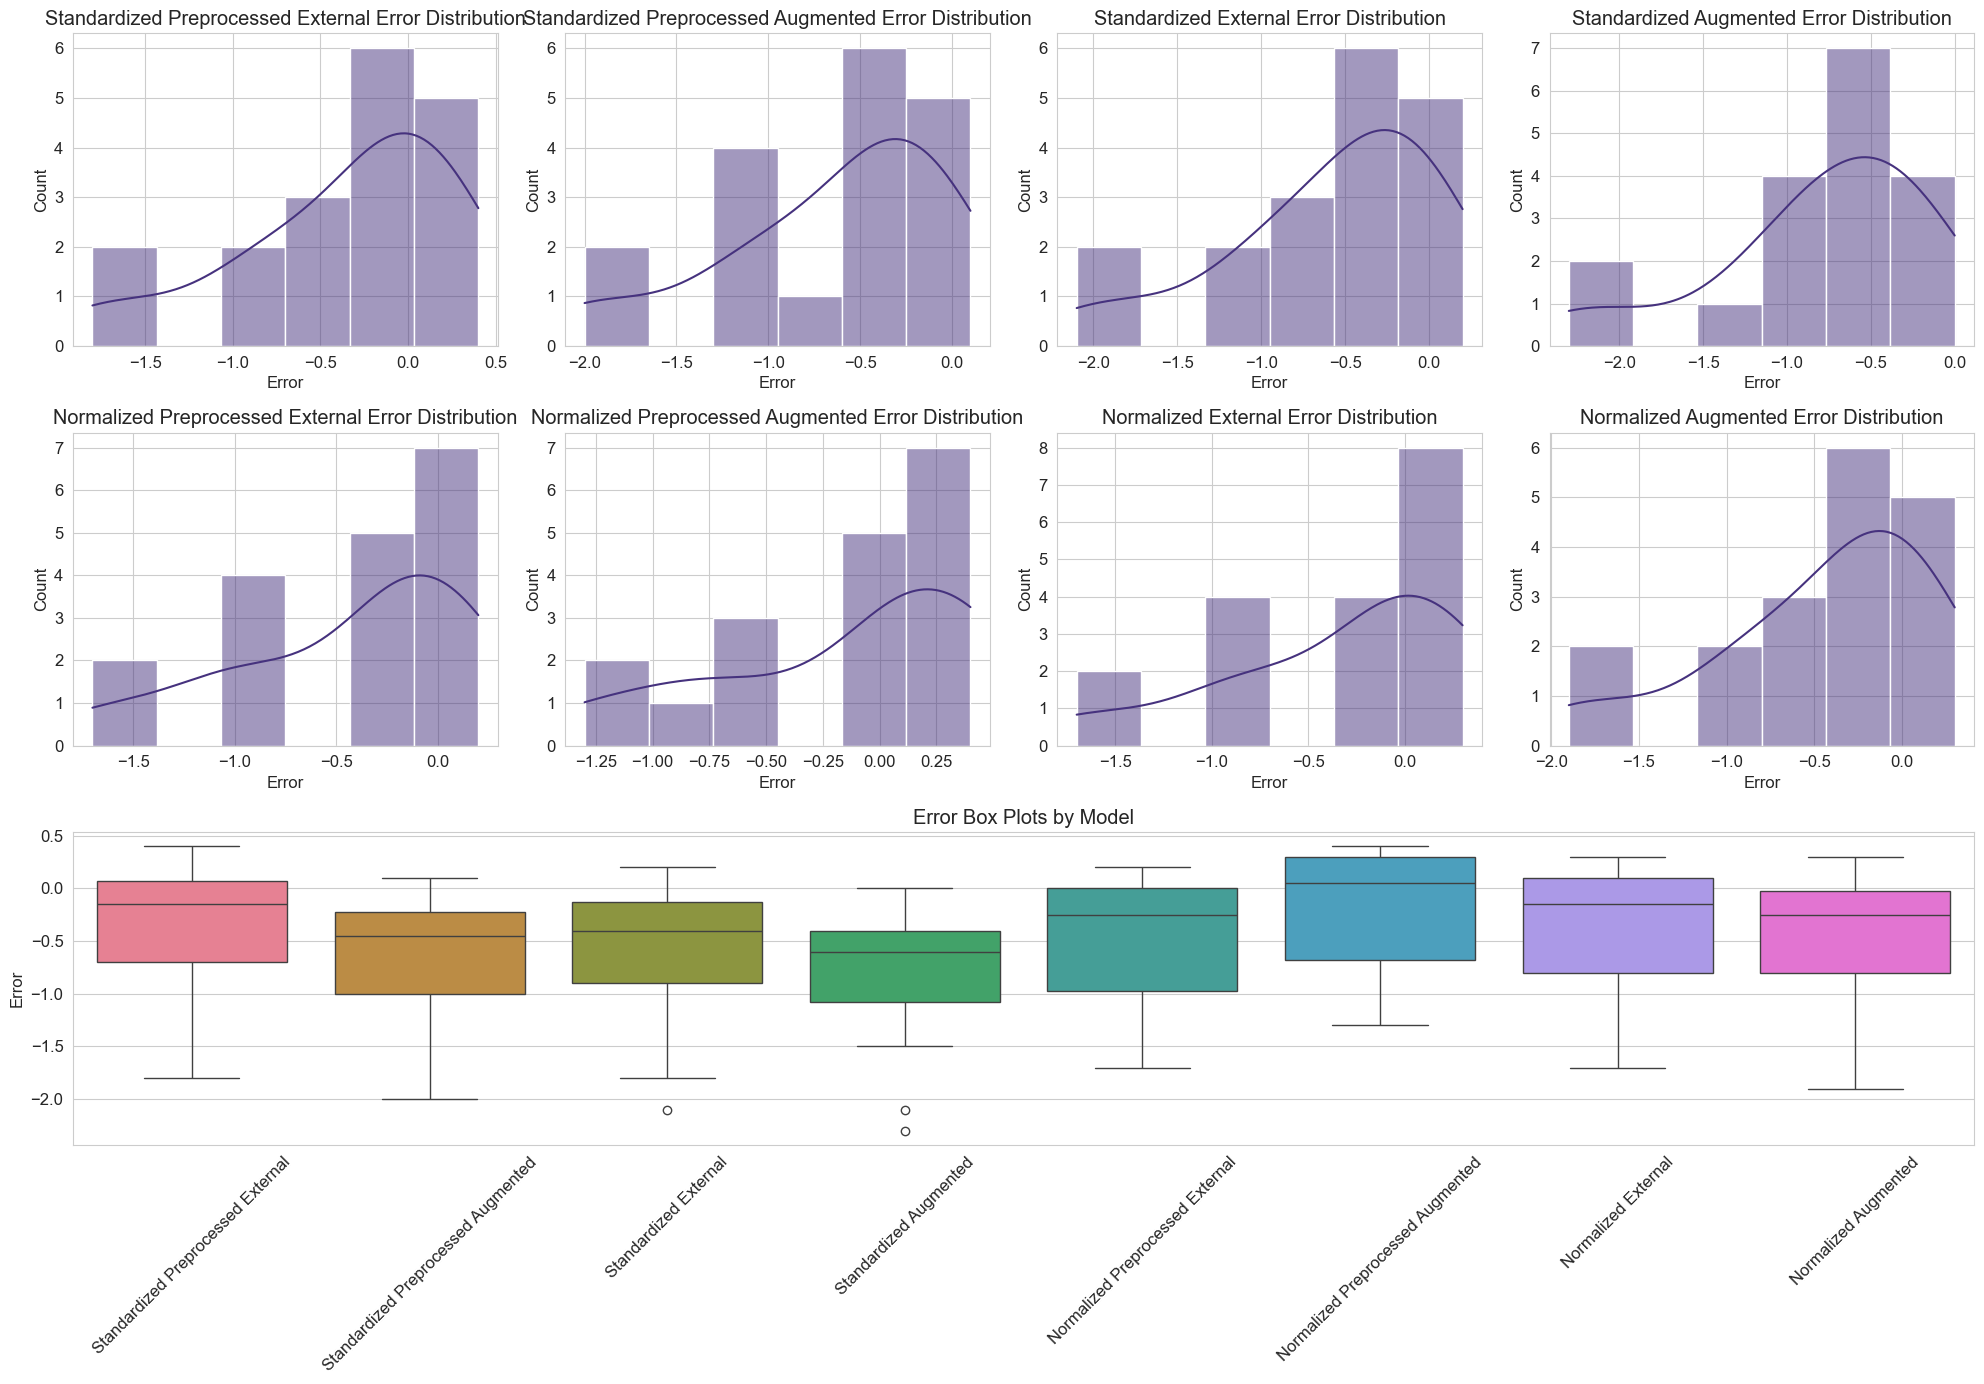

In [14]:
print("\nComparing models:")
ctodmetrics, ctodstats, ctodoverallstats, ctodnormality, ctodhomoscedasticity, ctodassumption, ctodstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'default')], ['cooled', 'default'], 'Tc', to_sort=False, plot=True)

### Cooled Room


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.851512 0.593373 0.725072  0.198570
Standardized Preprocessed Augmented 0.887663 0.601010 0.787945  0.129075
              Standardized External 0.906953 0.619374 0.822563  0.090811
             Standardized Augmented 1.094339 0.669532 1.197577 -0.323696
   Normalized Preprocessed External 0.706669 0.552770 0.499381  0.448028
  Normalized Preprocessed Augmented 0.693333 0.583269 0.480711  0.468665
                Normalized External 0.843466 0.567594 0.711435  0.213643
               Normalized Augmented 0.881068 0.598374 0.776282  0.141967

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.823099 0.668721 0.677491  0.104637
Standardized Preprocessed Augmented 0.840022 0.671049 0.705637  0.067440
              Stand

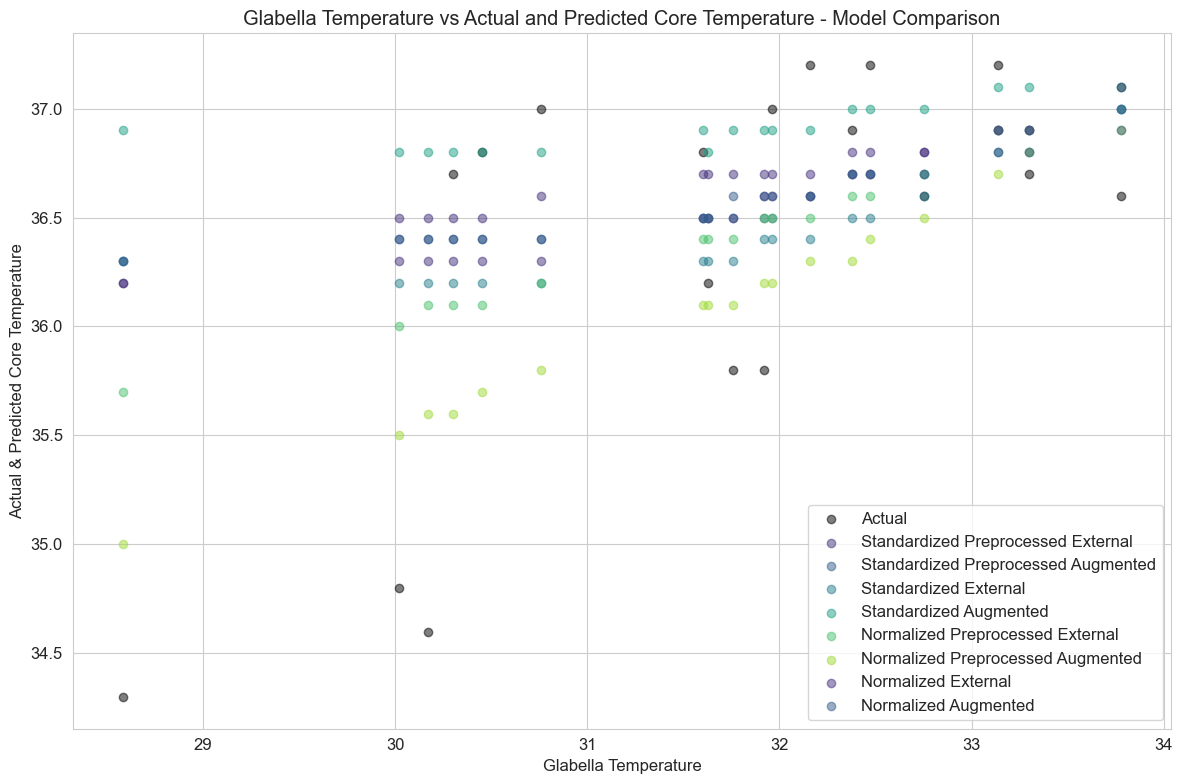

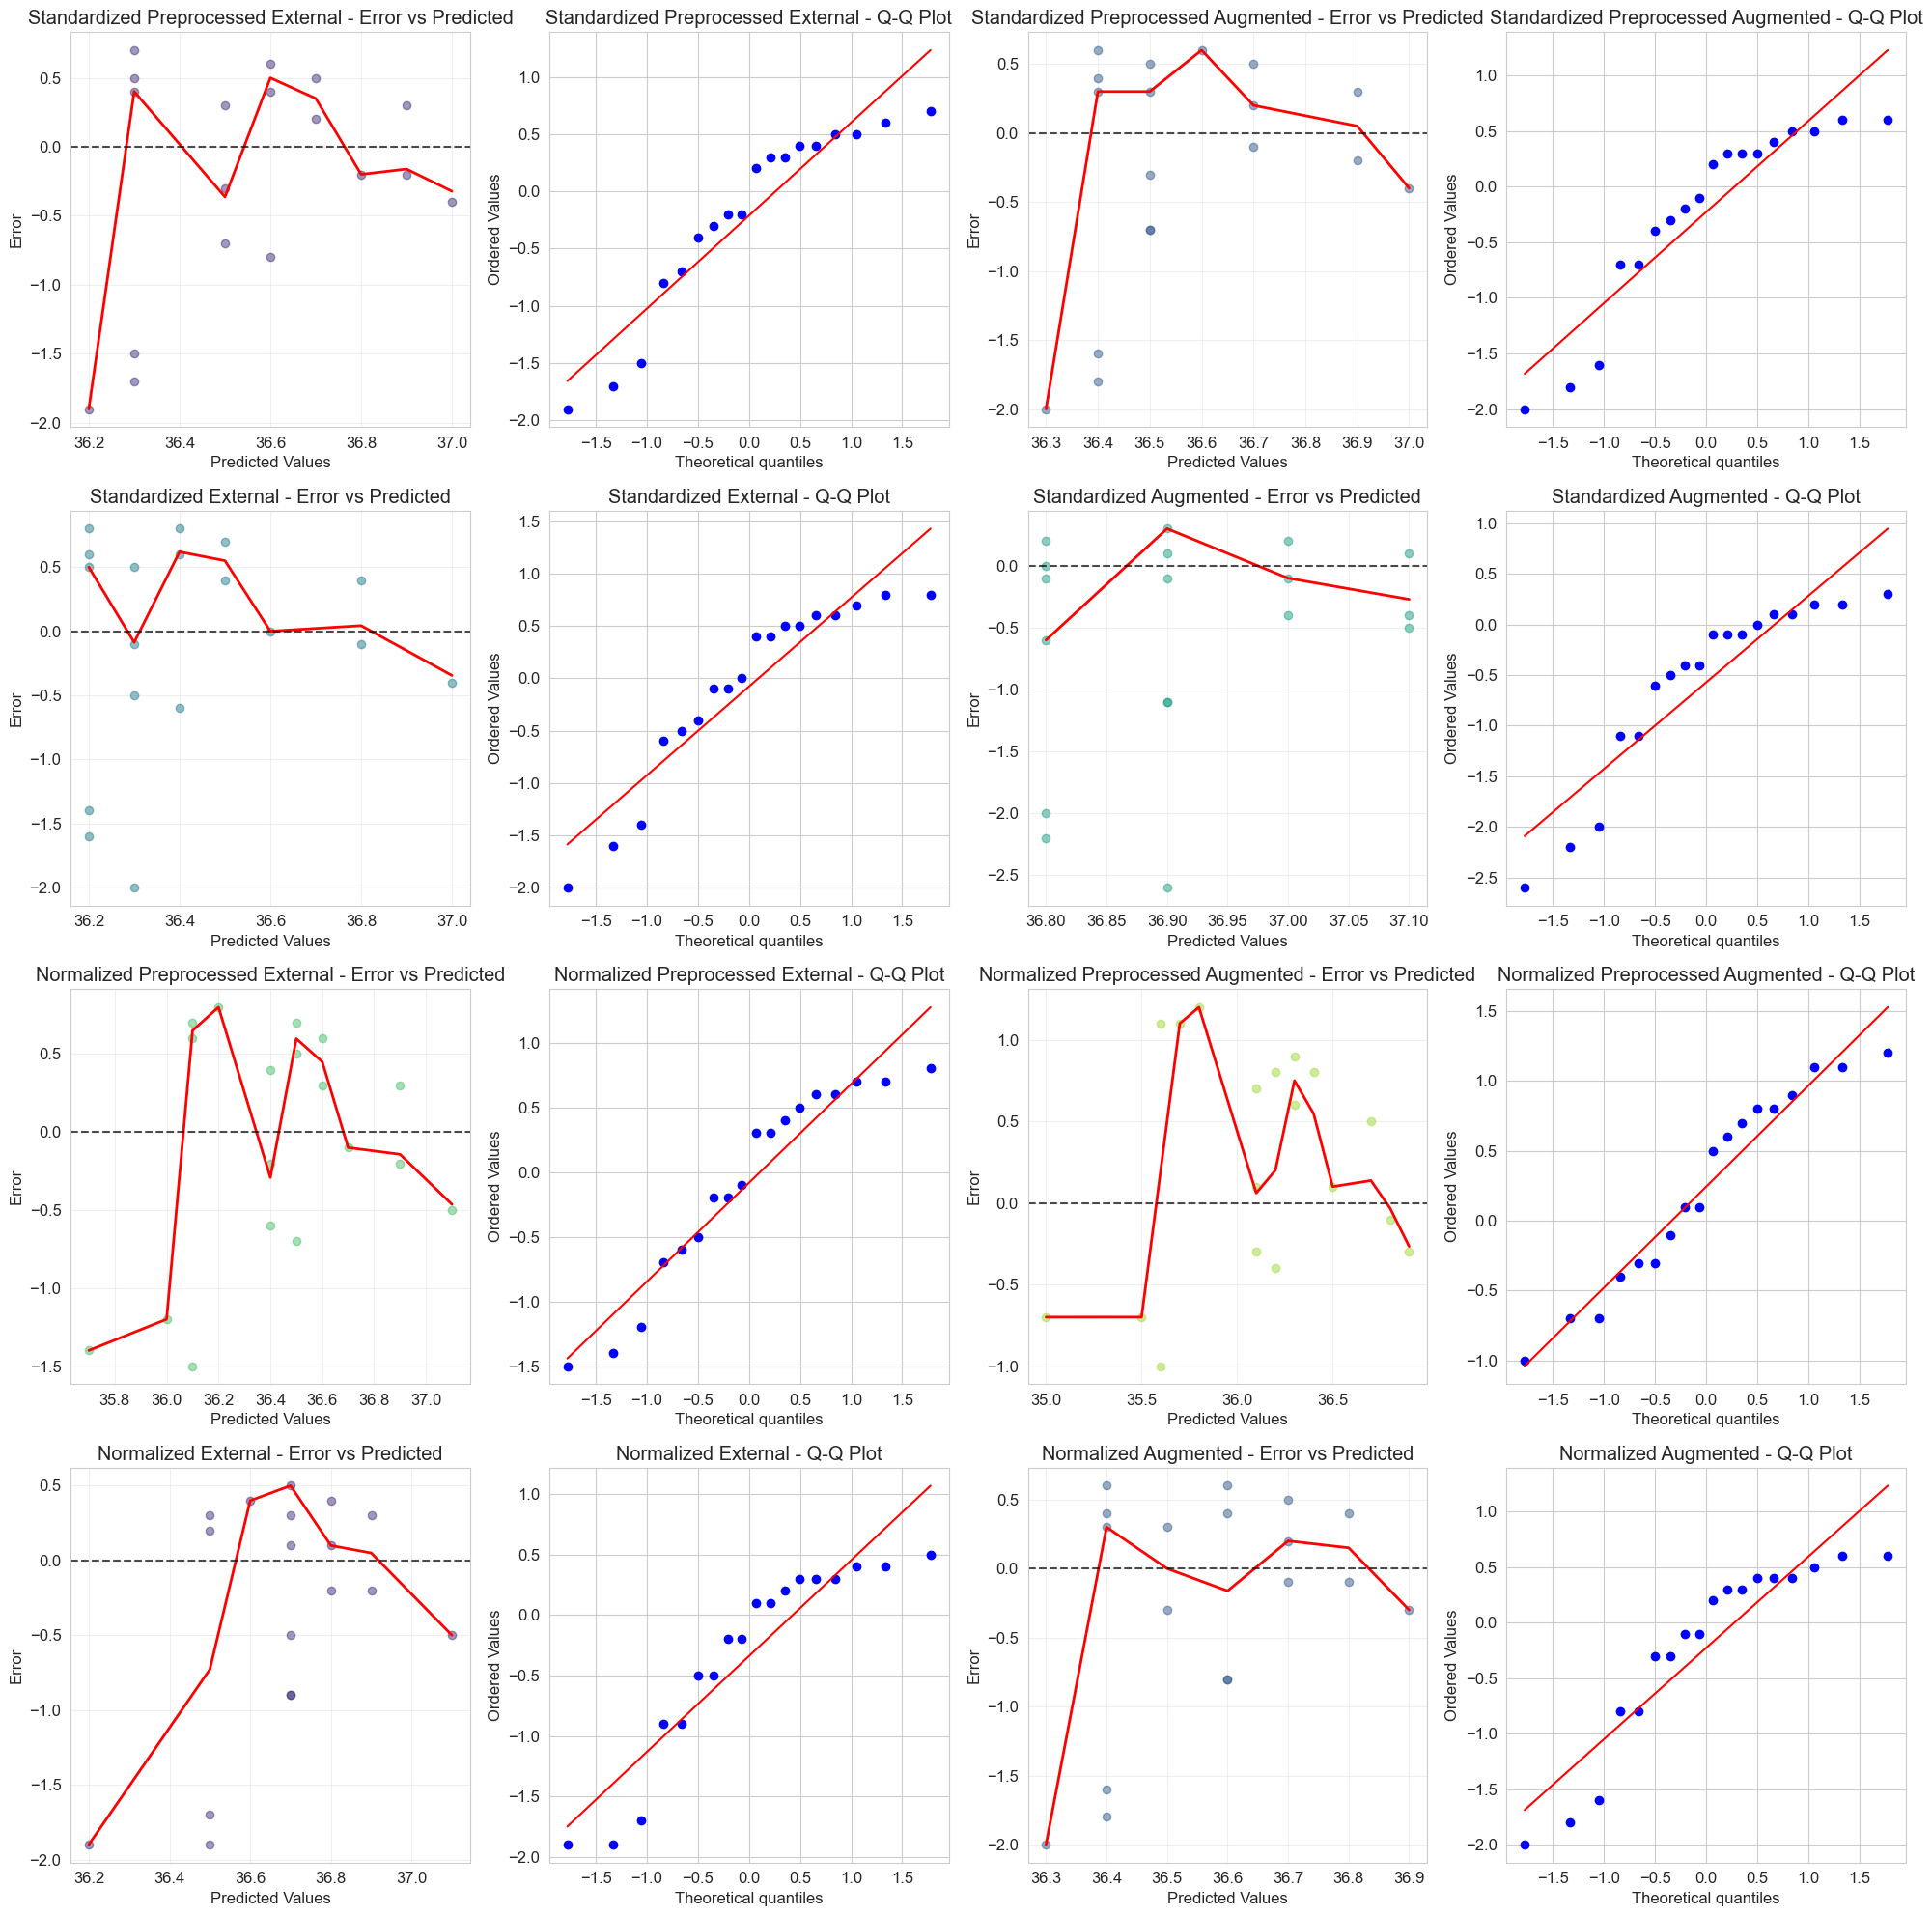

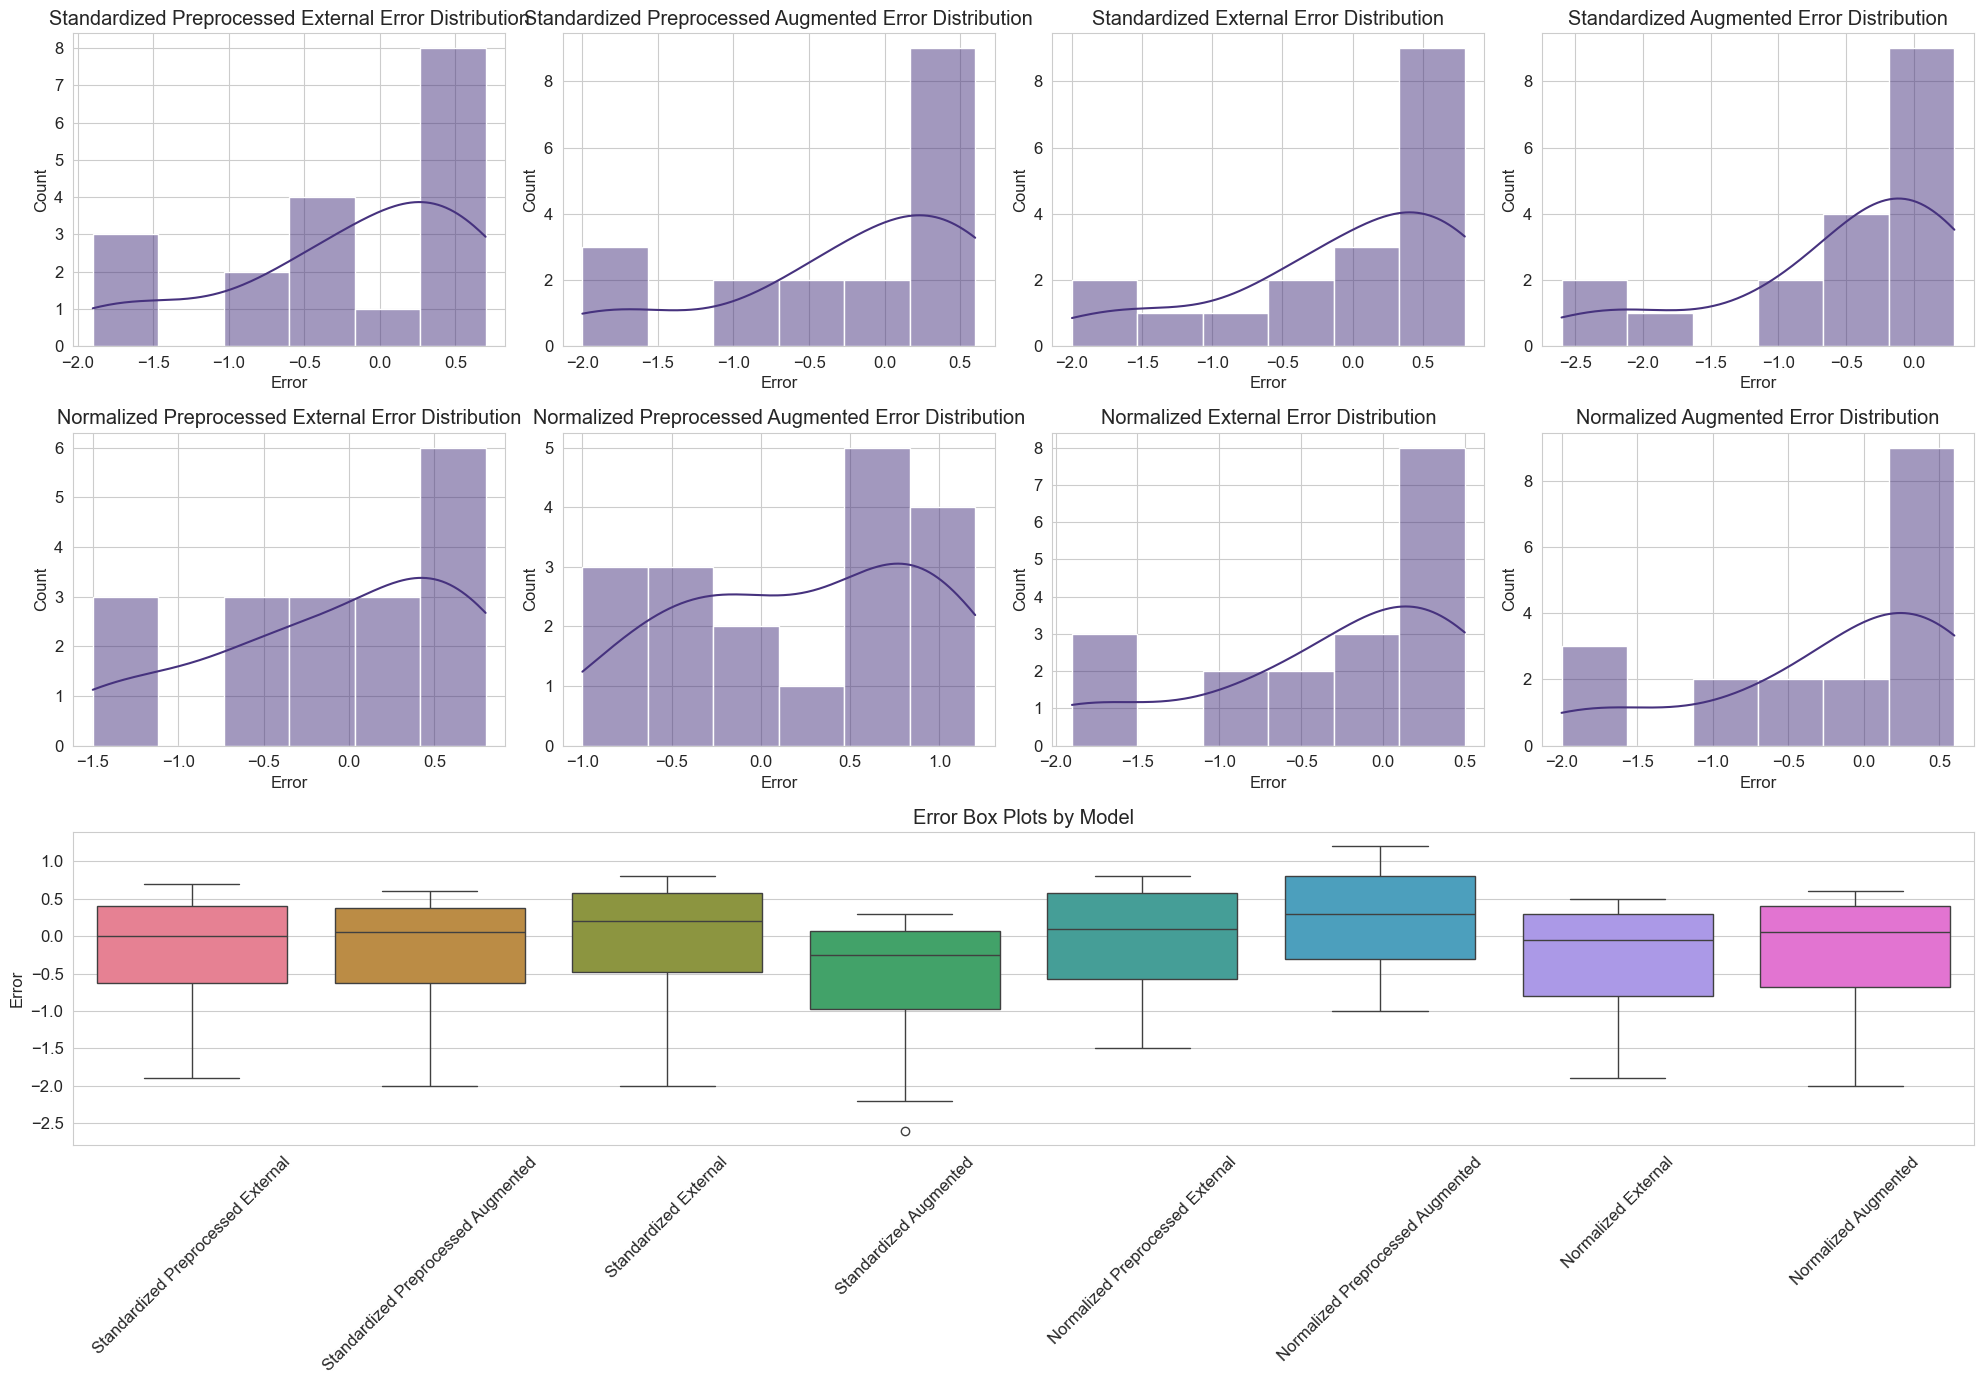

In [15]:
print("\nComparing models:")
ctocmetrics, ctocstats, ctocoverallstats, ctocnormality, ctochomoscedasticity, ctocassumption, ctocstats_test_result = manager.compare_models(test_data[(test_data['Hc'] == 'cooled') & (test_data['Rc'] == 'cooled')], ['cooled', 'cooled'], 'Tc', to_sort=False, plot=True)

## Overall


Comparing models:

---------------
 Trial 1 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.617912 0.429598 0.381815  0.045959
Standardized Preprocessed Augmented 0.676757 0.476012 0.458001 -0.144405
              Standardized External 0.667027 0.473073 0.444925 -0.111734
             Standardized Augmented 0.815748 0.577534 0.665444 -0.662744
   Normalized Preprocessed External 0.597970 0.439868 0.357569  0.106544
  Normalized Preprocessed Augmented 0.564669 0.452369 0.318851  0.203286
                Normalized External 0.616730 0.429392 0.380356  0.049606
               Normalized Augmented 0.636703 0.441432 0.405391 -0.012951

---------------
 Trial 2 
---------------
                              Model     RMSE      MAE      MSE        R²
 Standardized Preprocessed External 0.601403 0.461246 0.361685  0.093899
Standardized Preprocessed Augmented 0.656698 0.503931 0.431252 -0.080381
              Stand

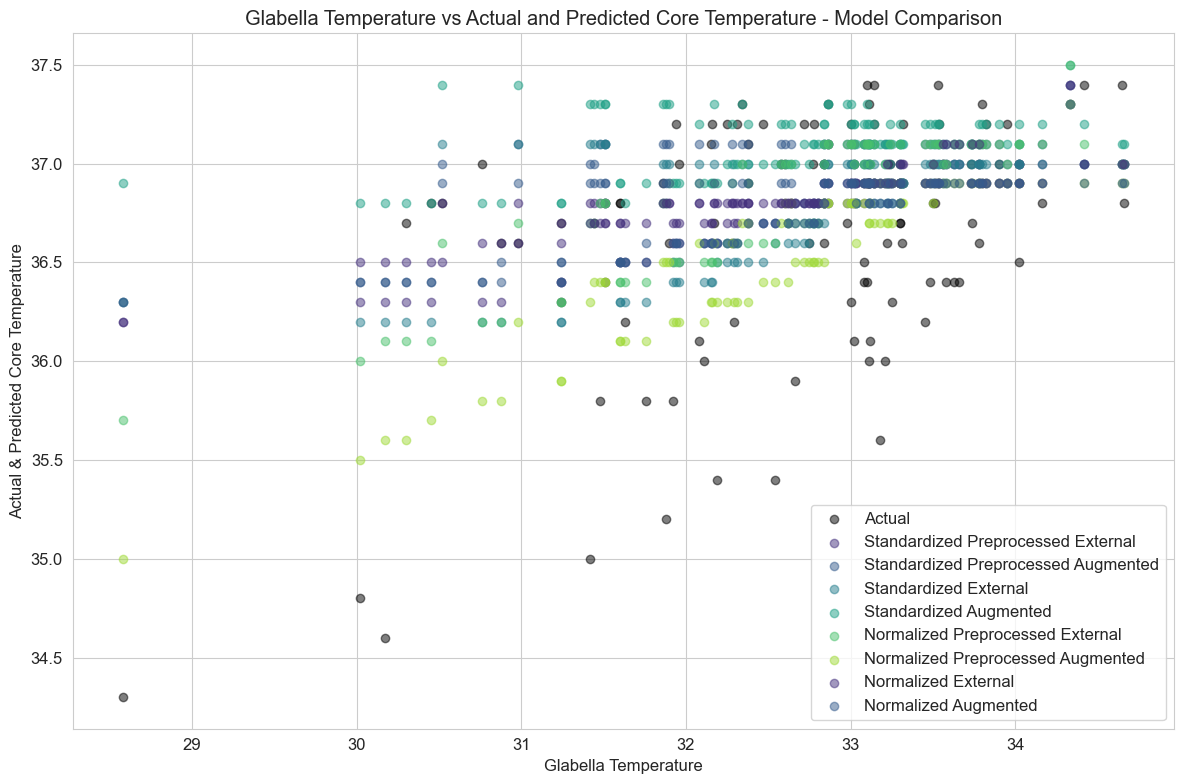

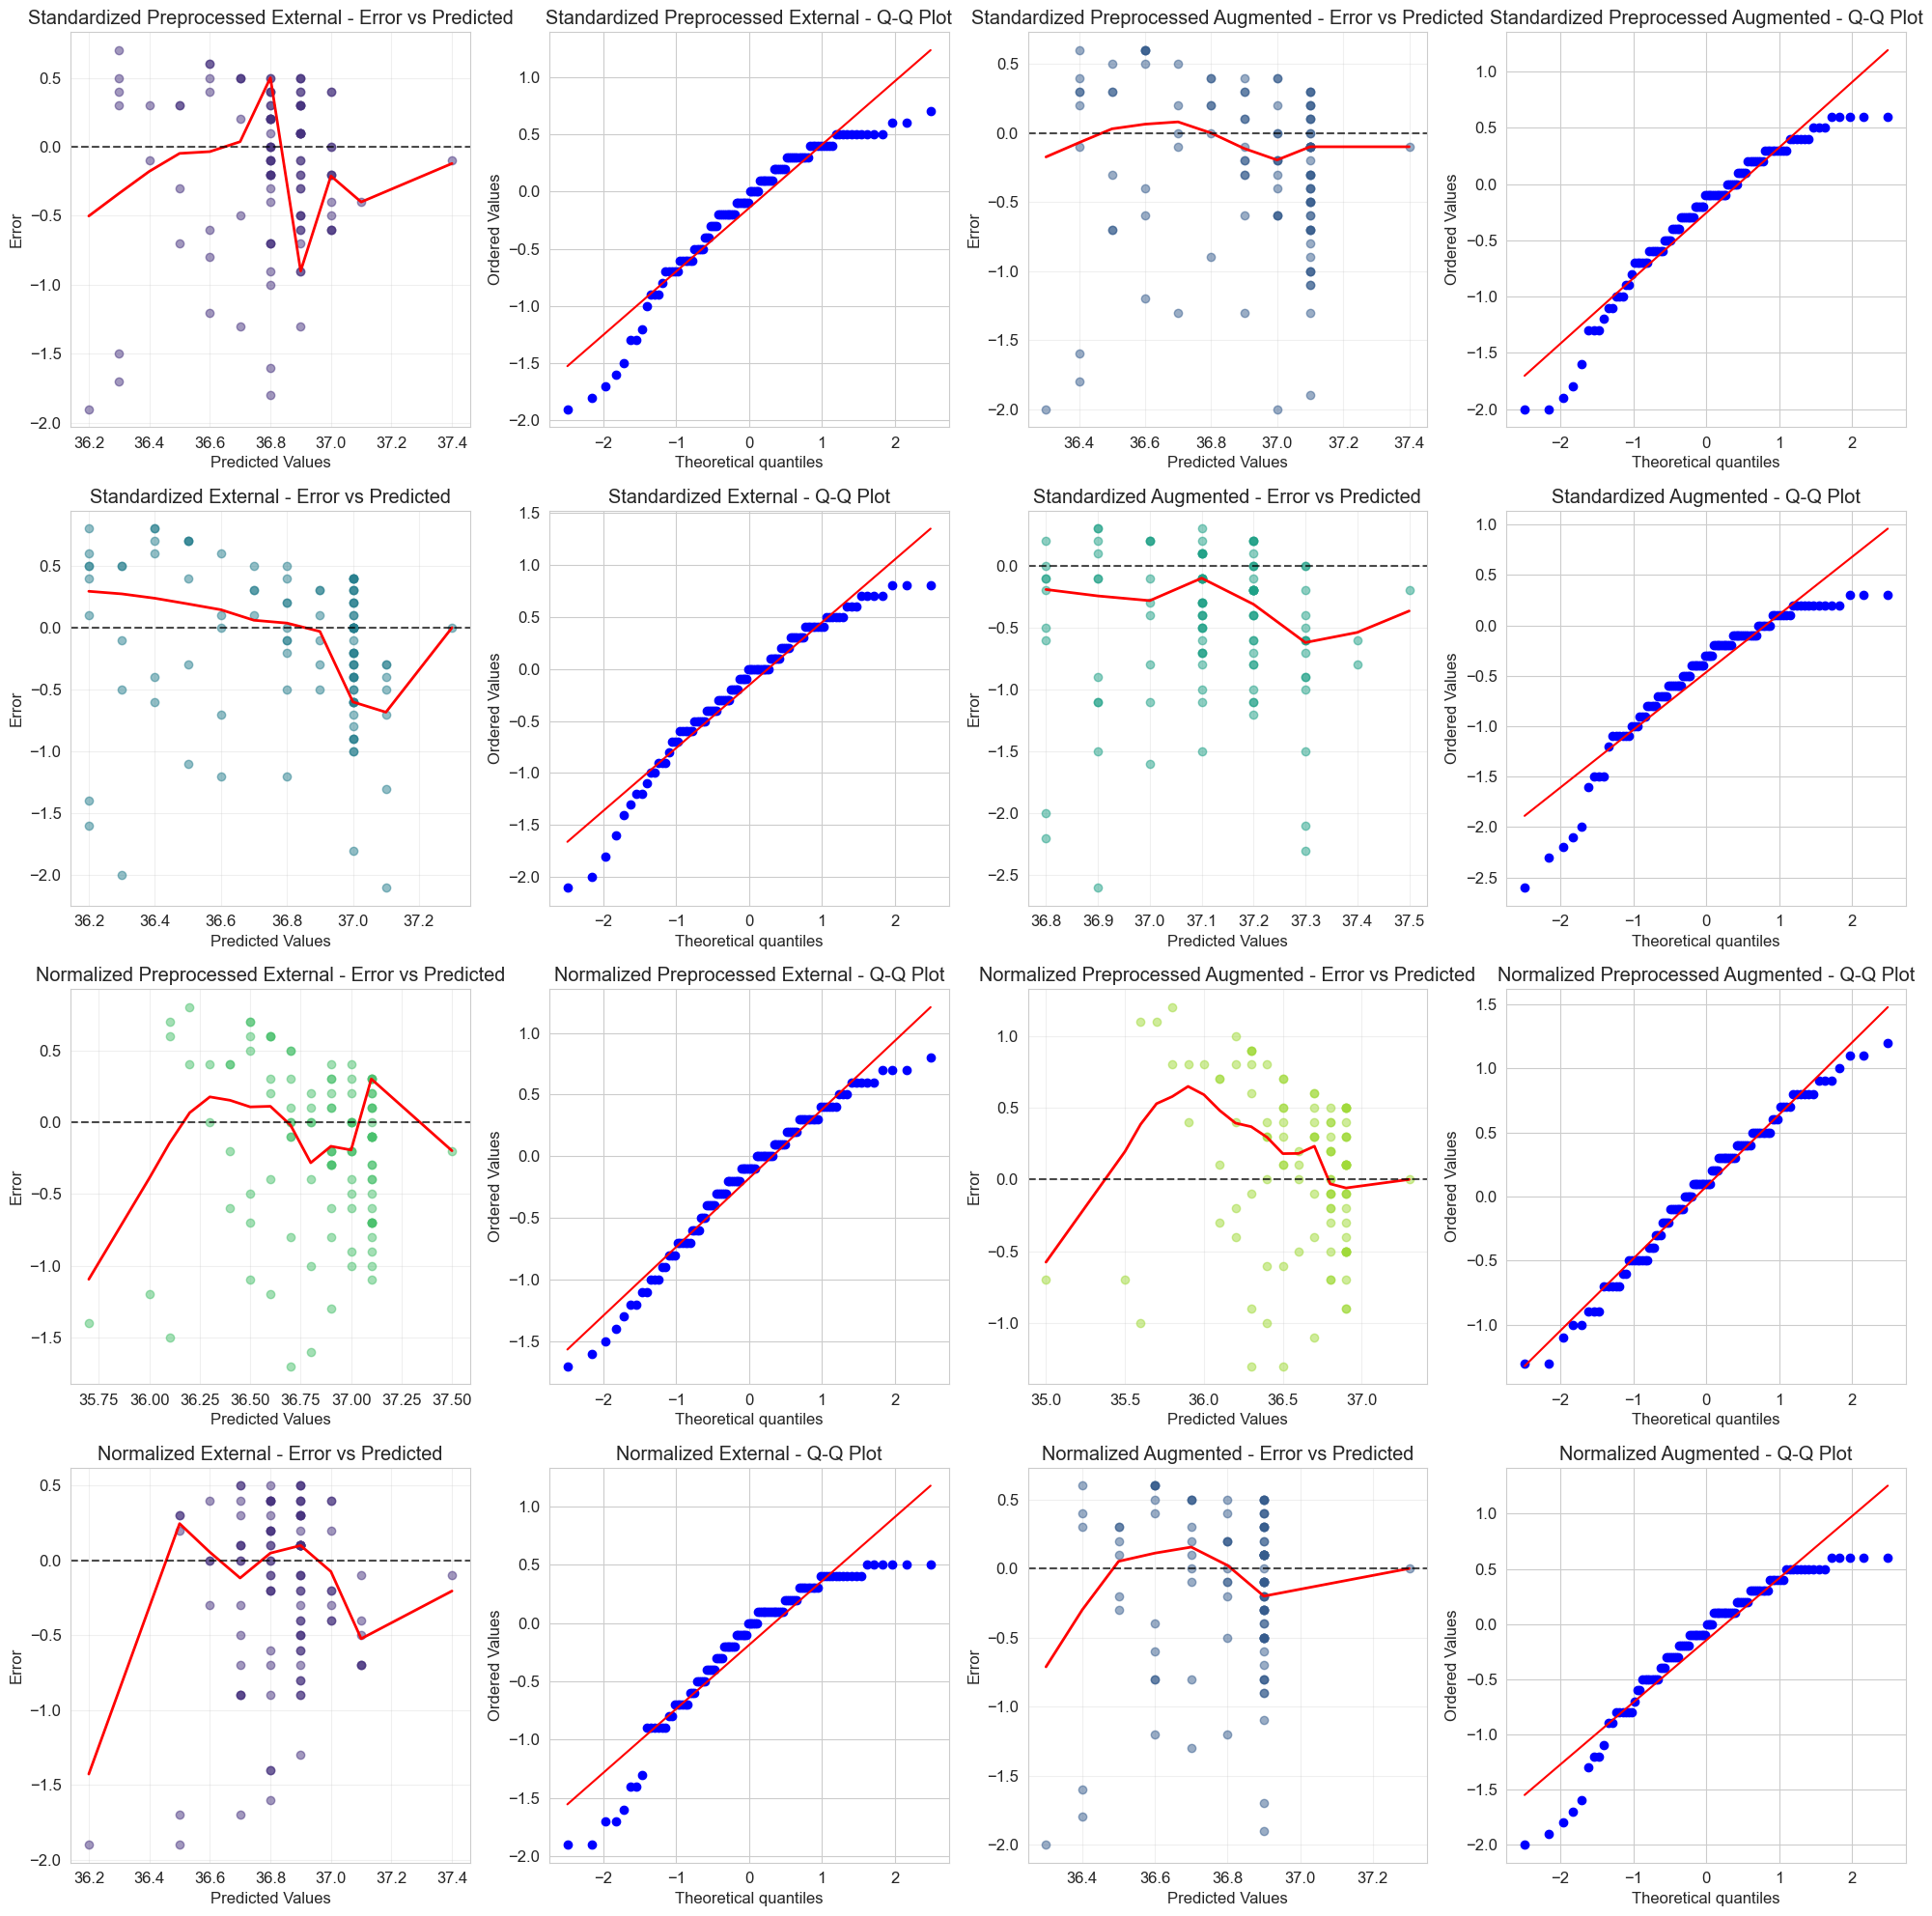

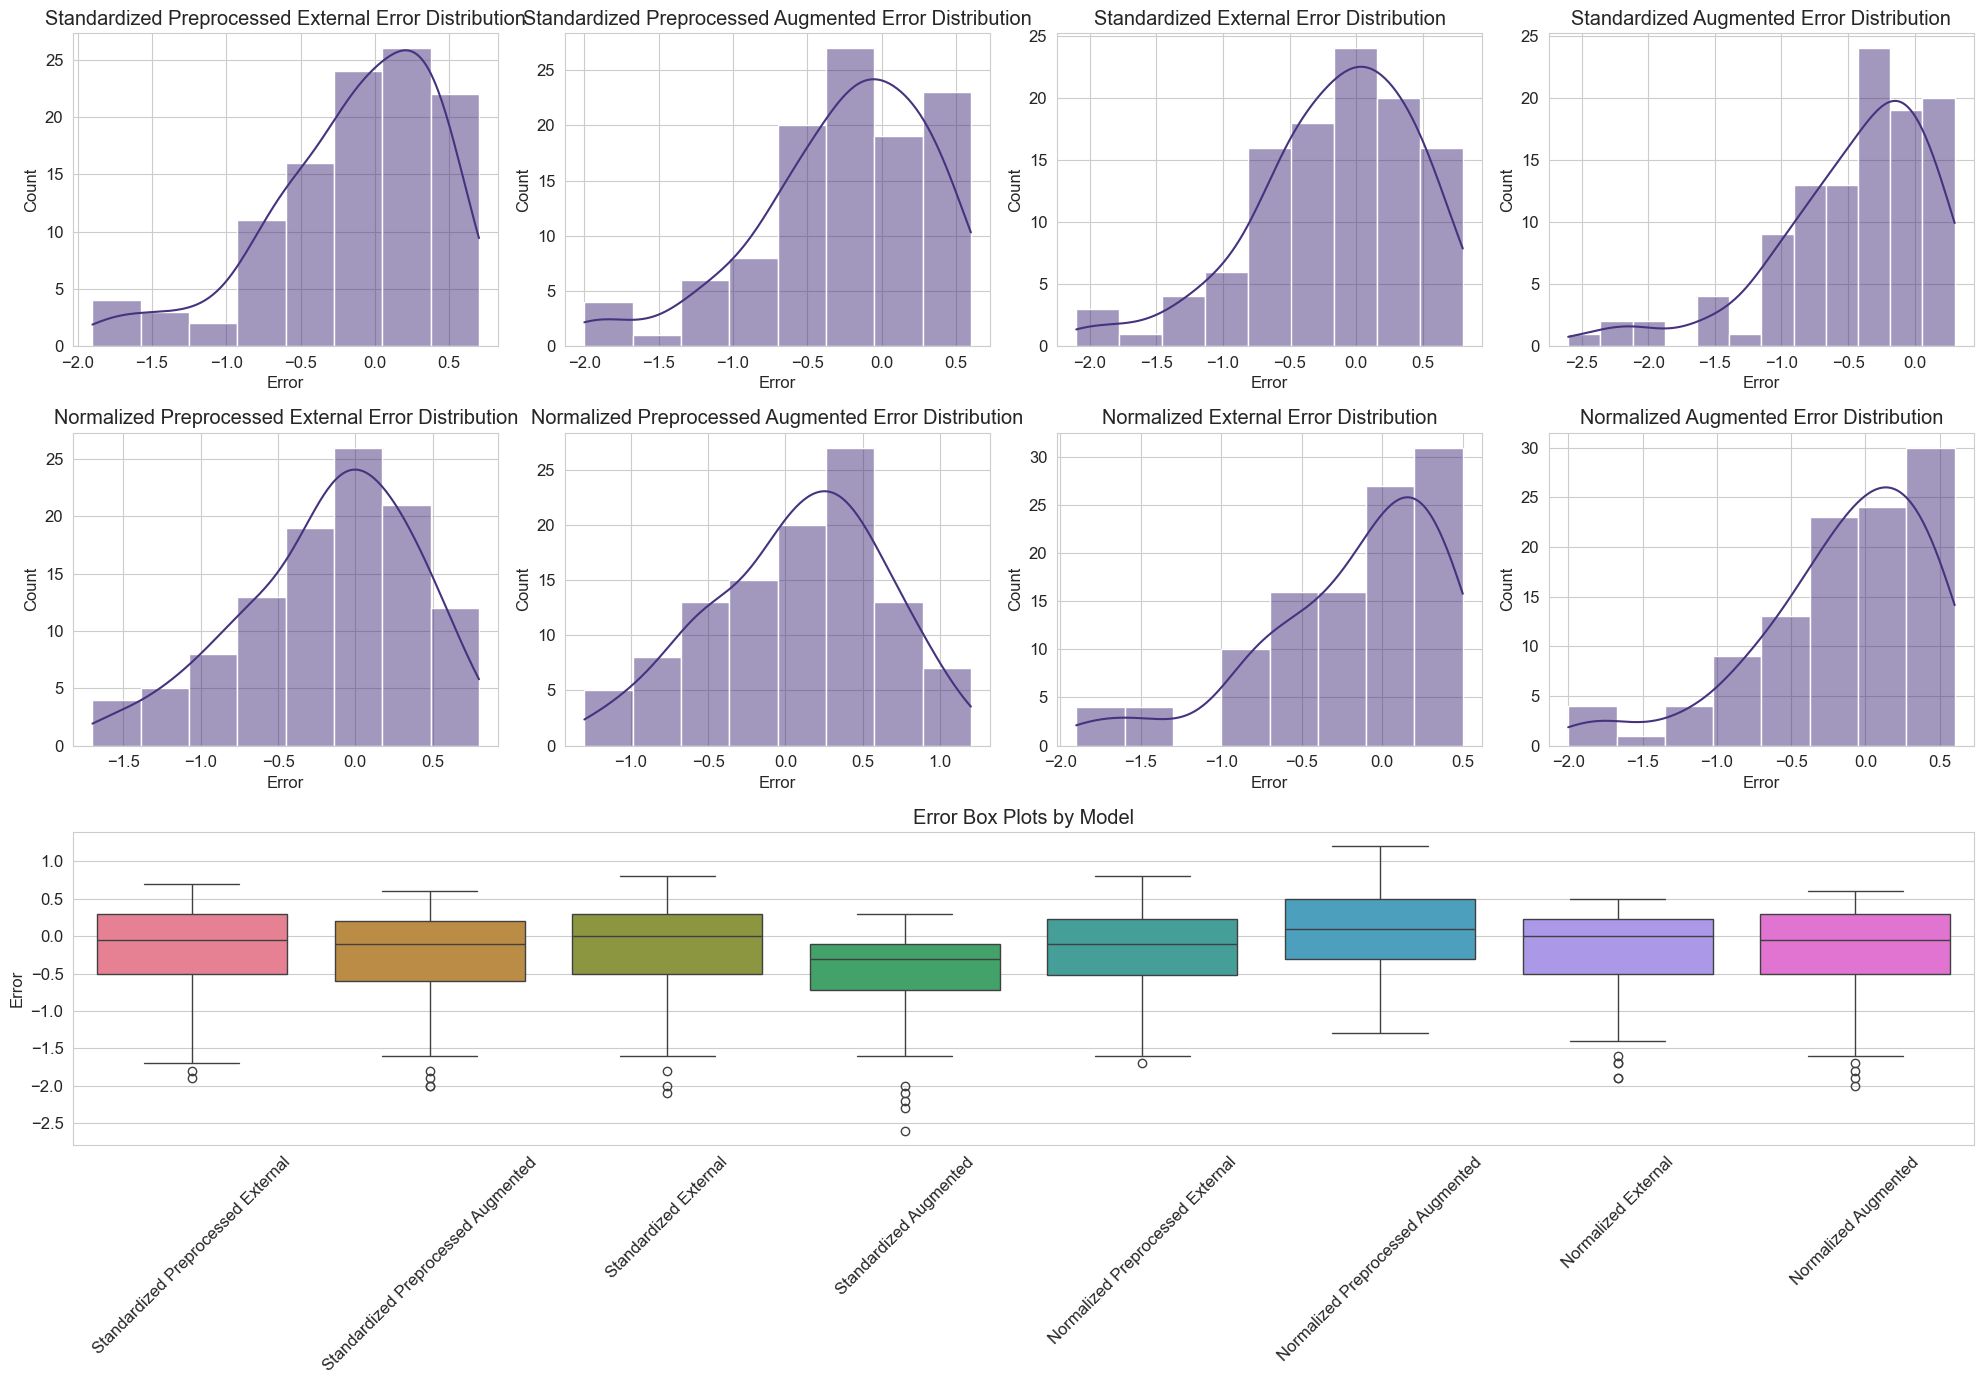

In [17]:
print("\nComparing models:")
overall_metrics, overall_stats, overall_overall_stats, overall_normality, overall_homoscedasticity, overall_assumption, overall_stats_test_result = manager.compare_models(test_data, ['overall', 'overall'], 'Tc', to_sort=False, plot=True)

# Statistical Significance Testing